#Overview

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

import warnings
# warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

import os

#use spotify api to correct data
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import re
import time
from difflib import SequenceMatcher
from spotipy.exceptions import SpotifyException


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/DSO528/Final_Project")

In [ ]:
data_1 = pd.read_csv("DSO528_project_spotify_1.csv")
data_2 = pd.read_csv("DSO528_project_spotify_2.csv")

In [ ]:
spotify_client_id = 'ab476f643d00473f84ab3ae6ea2c7cc5'
spotify_client_secret = 'f485b2c548f941e497e034dc985a3f7e'

#EDA

##Functions for EDA

**plot_value_count_distribution(df, eda_column, target_column, title=None)**

In [ ]:
def plot_value_count_distribution(df, eda_column, target_column, title=None):
    """
    Plots the value count distribution for a given column in the DataFrame.
    Then splits the value count by the target column classes (0 and 1),
    creating distribution plots and a box plot for outliers.

    Parameters:
        df (DataFrame): The input dataset.
        eda_column (str): The column to perform the value count and EDA on.
        target_column (str): The target column to split by class.
        title (str): The title of the plot (optional). Defaults to f"{eda_column} Value Count Distribution".
    """
    if title is None:
        title = f"{eda_column} Value Count Distribution"

    # Perform value counts for the column
    value_counts = df[eda_column].value_counts()

    # Create histogram of value counts
    plt.figure(figsize=(10, 6))
    plt.hist(value_counts, bins=20, color=plt.colormaps.get_cmap('tab20')(8), alpha=0.7)
    plt.title(f"{title} (All Data)")
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Split value counts by target column (0 and 1 classes)
    class_0_counts = df[df[target_column] == 0][eda_column].value_counts()
    class_1_counts = df[df[target_column] == 1][eda_column].value_counts()

    # Plot histogram for each class
    plt.figure(figsize=(10, 6))
    plt.hist(class_0_counts, bins=20, alpha=0.7, label='Class 0', color = plt.colormaps.get_cmap('tab20')(0))
    plt.hist(class_1_counts, bins=20, alpha=0.7, label='Class 1', color = plt.colormaps.get_cmap('tab20')(6))
    plt.title(f"{title} by {target_column}")
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Box plot for outliers by class
    value_count_df = pd.DataFrame({
        'Class 0': class_0_counts,
        'Class 1': class_1_counts
    }).stack().reset_index()
    value_count_df.columns = [eda_column, 'Class', 'Count']

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=value_count_df, x='Class', y='Count',
                hue = 'Class',
                palette= [plt.colormaps.get_cmap('tab20')(0), plt.colormaps.get_cmap('tab20')(6)] )
    plt.title(f"{eda_column} Value Count Box Plot by Class")
    plt.grid(axis='y', alpha=0.75)
    plt.show()



**plot_unique_track_count_distribution(df, eda_column, target_column=None, title=None)**

In [ ]:
def plot_unique_track_count_distribution(df, eda_column, target_column=None, title=None):
    """
    Plots the value count distribution for a given column in the DataFrame.
    Then splits the value count by the target column classes (0 and 1),
    creating distribution plots and a box plot for outliers.

    Parameters:
        df (DataFrame): The input dataset.
        eda_column (str): The column to perform the value count and EDA on.
        target_column (str): The target column to split by class.
        title (str): The title of the plot (optional). Defaults to f"{eda_column} Value Count Distribution".
    """

    if title is None:
        title = f"{eda_column} unique track Count Distribution"

    # Perform value counts for the column
    value_counts = df.groupby(eda_column)['track_id'].nunique()

    # Split value counts by target column (0 and 1 classes)
    class_0_counts = df[df[target_column] == 0].groupby(eda_column)['track_id'].nunique()
    class_1_counts = df[df[target_column] == 1].groupby(eda_column)['track_id'].nunique()
    # Plot histogram for each class
    plt.figure(figsize=(10, 6))
    plt.hist(value_counts, bins=20, alpha=0.7, label='All', color=plt.colormaps.get_cmap('tab20')(8))
    plt.hist(class_0_counts, bins=20, alpha=0.7, label='Unpopular', color = plt.colormaps.get_cmap('tab20')(0))
    plt.hist(class_1_counts, bins=20, alpha=0.7, label='Popular', color = plt.colormaps.get_cmap('tab20')(6))
    plt.title(f"{title} by {target_column}")
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Box plot for outliers by class
    value_count_df = pd.DataFrame({
        'All': value_counts,
        'Unpopular': class_0_counts,
        'Popular': class_1_counts
    }).fillna(0).stack().reset_index()
    value_count_df.columns = [eda_column, 'Class', 'Count']

    # summary_stats = value_count_df.groupby('Class')['Count'].describe()
    # print(summary_stats)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=value_count_df, x='Class', y='Count',
                hue = 'Class',
                palette= [plt.colormaps.get_cmap('tab20')(8),
                          plt.colormaps.get_cmap('tab20')(0),
                          plt.colormaps.get_cmap('tab20')(6)] )
    plt.title(f"{eda_column} Value Count Box Plot by Class")
    plt.grid(axis='y', alpha=0.75)
    plt.show()





**compute_track_metrics(data, variable_column, target_column)**

In [ ]:
def compute_track_metrics(data, variable_column, target_column):
    """
    Computes metrics for unique tracks by a specified variable (e.g., artist), including total, popular, and unpopular tracks.

    Parameters:
        data (DataFrame): The dataset containing the track information.
        variable_column (str): The column name for the grouping variable (e.g., 'track_artist').
        target_column (str): The column name indicating popularity (e.g., 'popular').

    Returns:
        DataFrame: A summary DataFrame with total, popular, and unpopular tracks per variable,
                   sorted by popular tracks in descending order.
    """
    # Hardcoded track column
    track_column = 'track_id'

    # Filter the data for popular and unpopular tracks
    popular_tracks = data[data[target_column] == 1].groupby(variable_column)[track_column].nunique()
    unpopular_tracks = data[data[target_column] == 0].groupby(variable_column)[track_column].nunique()

    # Compute total unique tracks
    total_tracks = data.groupby(variable_column)[track_column].nunique()

    # Combine all metrics into a single DataFrame
    result = pd.DataFrame({
        'total_tracks': total_tracks,
        'popular_tracks': popular_tracks,
        'unpopular_tracks': unpopular_tracks
    }).fillna(0)  # Fill missing values with 0 if a variable has no popular/unpopular tracks

    # Convert counts to integers and sort by popular tracks
    result = result.astype(int).sort_values(by='popular_tracks', ascending=False)

    # Print summary statistics
    print(result.describe())

    # Return the result DataFrame
    return result


In [ ]:
def analyze_column_distribution_continuous(dataframe, column_to_analysis):
    # Group by track_id and calculate mean values for each track_id
    grouped_data = dataframe.groupby('track_id').agg({
        column_to_analysis: 'mean',  # Average the column_to_analysis for unique track_id
        'popular': 'first'  # Assuming popularity is consistent for the same track_id
    }).reset_index()

    # Calculate summary statistics
    overall_stats = grouped_data[column_to_analysis].describe()
    popular_stats = grouped_data[grouped_data['popular'] == 1][column_to_analysis].describe()
    unpopular_stats = grouped_data[grouped_data['popular'] == 0][column_to_analysis].describe()

    summary_df = pd.DataFrame({
        'Overall': overall_stats,
        'Popular == 1': popular_stats,
        'Popular == 0': unpopular_stats
    })

    # Display the summary statistics DataFrame
    print("Summary Statistics:")
    print(summary_df)

    # Overlapping histogram
    plt.figure(figsize=(10, 6))

    # Overall distribution
    plt.hist(grouped_data[column_to_analysis], bins=20, alpha=0.5,
             color=plt.colormaps.get_cmap('tab20')(8), label='Overall')

    # Unpopular distribution
    plt.hist(grouped_data[grouped_data['popular'] == 0][column_to_analysis], bins=20, alpha=0.5,
             color=plt.colormaps.get_cmap('tab20')(0), label='Popular == 0')

    # Popular distribution (solid red)
    plt.hist(grouped_data[grouped_data['popular'] == 1][column_to_analysis], bins=20, alpha=1,
             color=plt.colormaps.get_cmap('tab20')(6), label='Popular == 1')

    plt.title(f"{column_to_analysis} Distribution (Unique Tracks)")
    plt.xlabel(column_to_analysis)
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

    # Boxplots
    plt.figure(figsize=(8, 6))
    grouped_data.boxplot(column=column_to_analysis, by='popular', grid=False, showmeans=True, notch=True)
    plt.title(f"{column_to_analysis} Distribution by Popularity (Unique Tracks)")
    plt.suptitle("")  # Remove default title
    plt.xlabel("Popularity (0 = Unpopular, 1 = Popular)")
    plt.ylabel(column_to_analysis)
    plt.show()


In [ ]:
# Function to calculate distribution counts for any categorical variable
def calculate_categorical_distribution(dataframe, column_name):
    # Group by track_id to ensure unique tracks
    grouped_data = dataframe.groupby('track_id').agg({
        column_name: 'first',  # Get the first value of the categorical column
        'popular': 'first'  # Assuming popularity is consistent for the same track_id
    }).reset_index()

    # Count distribution for all, popular == 1, and popular == 0
    all_categories = grouped_data[column_name].value_counts().sort_index()
    popular_categories = grouped_data[grouped_data['popular'] == 1][column_name].value_counts().sort_index()
    unpopular_categories = grouped_data[grouped_data['popular'] == 0][column_name].value_counts().sort_index()

    # Combine results into a DataFrame
    category_distribution = pd.DataFrame({
        'All Tracks': all_categories.astype(int),
        'Popular Tracks': popular_categories.astype(int),
        'Unpopular Tracks': unpopular_categories.astype(int),
        'Popular Ratio': (popular_categories / all_categories).fillna(0).astype(float)
    }).fillna(0)  # Fill NaN with 0 and convert to int

    category_distribution.sort_values(by='Popular Ratio', ascending=False, inplace=True)

    # Plot overlapping histograms
    plt.figure(figsize=(10, 6))
    plt.hist(grouped_data[column_name], bins=len(all_categories), alpha=0.5, label='All Tracks', color=plt.colormaps.get_cmap('tab20')(8))
    plt.hist(grouped_data[grouped_data['popular'] == 0][column_name], bins=len(all_categories), alpha=0.5, label='Unpopular Tracks', color=plt.colormaps.get_cmap('tab20')(0))
    plt.hist(grouped_data[grouped_data['popular'] == 1][column_name], bins=len(all_categories), alpha=1, label='Popular Tracks', color=plt.colormaps.get_cmap('tab20')(6))
    plt.title(f"Distribution of {column_name.capitalize()}")
    plt.xlabel(column_name.capitalize())
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.xticks(range(len(all_categories)), all_categories.index, rotation=45)
    plt.show()

    # Plot boxplot (if applicable)
    if pd.api.types.is_numeric_dtype(dataframe[column_name]):
        plt.figure(figsize=(8, 6))
        grouped_data.boxplot(column=column_name, by='popular', grid=False, showmeans=True, notch=True)
        plt.title(f"{column_name.capitalize()} Distribution by Popularity")
        plt.suptitle("")  # Remove default title
        plt.xlabel("Popularity (0 = Unpopular, 1 = Popular)")
        plt.ylabel(column_name.capitalize())
        plt.xticks([1, 2], ["Unpopular", "Popular"])  # Rename the x-axis ticks for clarity
        plt.show()

    return category_distribution


In [ ]:
def plot_boxplots_by_genre(data, numerical_columns, category_column='playlist_genre'):
    """
    Generates boxplots for each numerical column grouped by a categorical column.

    Parameters:
        data (pd.DataFrame): The dataset.
        numerical_columns (list): List of numerical columns to plot.
        category_column (str): The categorical column to group by (default is 'playlist_genre').
    """
    for column in numerical_columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=data, x=category_column, y=column, hue = category_column, palette='Set3')
        plt.title(f"{column.capitalize()} by {category_column.replace('_', ' ').capitalize()}")
        plt.xticks(rotation=45)
        plt.xlabel(category_column.replace('_', ' ').capitalize())
        plt.ylabel(column.capitalize())
        plt.tight_layout()
        plt.show()


In [ ]:
def plot_yearly_trends(data, numerical_column, group_column='release_year'):
    """
    Aggregates average values of a numerical column by a grouping column
    and plots yearly trends for all, popular, and unpopular tracks.

    Parameters:
        data (pd.DataFrame): The dataset.
        numerical_column (str): The numerical column to analyze (e.g., 'tempo').
        group_column (str): The column to group by (default is 'release_year').
    """
    # Calculate yearly averages for all, popular, and unpopular tracks
    all_trends = data.groupby(group_column)[numerical_column].mean().reset_index()
    popular_trends = data[data['popular'] == 1].groupby(group_column)[numerical_column].mean().reset_index()
    unpopular_trends = data[data['popular'] == 0].groupby(group_column)[numerical_column].mean().reset_index()

    # Rename columns for clarity
    all_trends.rename(columns={numerical_column: 'All Tracks'}, inplace=True)
    popular_trends.rename(columns={numerical_column: 'Popular Tracks'}, inplace=True)
    unpopular_trends.rename(columns={numerical_column: 'Unpopular Tracks'}, inplace=True)

    # Merge all trends into a single DataFrame
    merged_trends = all_trends.merge(popular_trends, on=group_column, how='left')
    merged_trends = merged_trends.merge(unpopular_trends, on=group_column, how='left')

    # Plot the trends
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=merged_trends, x=group_column, y='All Tracks', label='All Tracks', color='blue', linewidth=2)
    sns.lineplot(data=merged_trends, x=group_column, y='Popular Tracks', label='Popular Tracks', color='red', linewidth=2)
    sns.lineplot(data=merged_trends, x=group_column, y='Unpopular Tracks', label='Unpopular Tracks', color='green', linewidth=2)

    # Add plot details
    plt.title(f"Yearly Trend of {numerical_column.capitalize()}", fontsize=14)
    plt.xlabel(group_column.replace('_', ' ').capitalize(), fontsize=12)
    plt.ylabel(f"Average {numerical_column.capitalize()}", fontsize=12)
    plt.legend(title="Category")
    plt.grid(alpha=0.3)
    plt.show()



## Initial Data Overview

**data_1**

This dataset contains older songs, with a large sample of both popular and less popular
tracks based on historical performance up to March 2020. At the time of data collection,
all songs had been released for at least two months.

| **data_1 Feature**        | **Description**                                                                                                                                                                                                                                          |
|---------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **track_id**       | A unique ID for the song.                                                                                                                                                                                                                               |
| **track_name**     | The name of the song.                                                                                                                                                                                                                                   |
| **track_artist**   | The name of the artist of the song.                                                                                                                                                                                                                     |
| **popular**        | 1 if the song is popular and 0 if not. Popularity is evaluated based on various factors, including Spotify popularity score. It is influenced by total number of plays and recency of plays.                                                             |
| **release_year**   | Year the song was released.                                                                                                                                                                                                                             |
| **release_month**  | Month of the year the song was released.                                                                                                                                                                                                               |
| **playlist_genre** | The genre of the song (e.g., rap, rock, country).                                                                                                                                                                                                       |
| **danceability**   | How suitable a track is for dancing based on tempo, rhythm stability, beat strength, and regularity. A value of 0.0 is least danceable, and 1.0 is most danceable.                                                                                      |
| **energy**         | A measure from 0.0 to 1.0 representing perceptual intensity and activity. High-energy tracks feel fast, loud, and noisy (e.g., death metal), while low-energy tracks (e.g., Bach preludes) feel calm and quiet.                                          |
| **key**            | The key of the song.                                                                                                                                                                                                                                   |
| **loudness**       | The overall loudness of a track in decibels (dB), typically ranging between -60 and 0 dB. Useful for comparing the relative loudness of tracks.                                                                                                         |
| **mode**           | Indicates whether the song is in a major or minor key.                                                                                                                                                                                                 |
| **speechiness**    | Detects the presence of spoken words. Higher values (closer to 1.0) indicate a track dominated by speech, while lower values represent mostly music.                                                                                                   |
| **acousticness**   | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.                                                                                                                            |
| **instrumentalness**| Detects whether a track contains no vocals. Higher values (closer to 1.0) indicate a higher likelihood of no vocal content. Values above 0.5 likely represent instrumental tracks.                                                                      |
| **liveness**     | Detects the presence of an audience in the recording. Higher values (above 0.8) indicate a strong likelihood that the track was performed live.                                                                                                         |
| **valence**        | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Higher valence values sound more positive, while lower valence values sound more negative.                                                                           |
| **tempo**          | The overall estimated tempo of a track in beats per minute (BPM), indicating the speed or pace of the track.                                                                                                                                           |
| **duration_ms**    | The duration of the track, in milliseconds.                                                                                                                                                                                                            |


In [ ]:
print(data_1.shape)
data_1.head(5)

(26266, 19)


track_id    track_name    track_artist  popular release_year  \
0  697MjF1454XKvZmTuqkWmD    I Miss You          Jeriqo        0         2019   
1  3x2bXiU0o4WbsPkawXlfDA   Who Are You         The Who        0         1978   
2  0jEaPBjFAWjQTMVouRwaHi         Happy  The Beef Seeds        0         2015   
3  5EKUb1FKsyYVaSXb41YBIj           ONE      Rev Theory        0         2020   
4  300DUx4tdtCdGEUXR032jA  Palace/Curse    The Internet        0         2015   

  release_month playlist_genre  danceability  energy  key  loudness  mode  \
0             2            edm         0.520   0.789    0    -7.717     1   
1             8           rock         0.651   0.661    9   -11.405     1   
2             1            r&b         0.640   0.758   10    -5.204     1   
3             1           rock         0.398   0.966    4    -2.352     0   
4             6            r&b         0.447   0.625   10    -8.212     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0432      0.004910          0.000013    0.0816    0.415  174.026   
1       0.0511      0.265000          0.003130    0.1060    0.489  156.371   
2       0.1600      0.665000          0.000000    0.1270    0.932   86.529   
3       0.0453      0.000006          0.000000    0.3030    0.520   90.016   
4       0.3230      0.035100          0.000727    0.2430    0.261   67.104   

   duration_ms  
0       216347  
1       378707  
2       218044  
3       208196  
4       440013

**data_2**

This dataset contains a small sample of popular songs from recent years. Along with
various song features, it includes total stream up to 2023. The company used this data to
estimate potential revenue from popular songs.

| **data_2 Feature**          | **Description**                                                                                                                                                                                                                                          |
|-----------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **track_name**       | The name of the song.                                                                                                                                                                                                                                   |
| **artist(s)_name**   | The name(s) of the artist(s) of the song.                                                                                                                                                                                                               |
| **artist_count**     | The number of artists involved in the song.                                                                                                                                                                                                            |
| **released_year**    | The year the song was released.                                                                                                                                                                                                                         |
| **released_month**   | The month of the year the song was released.                                                                                                                                                                                                           |
| **released_day**     | The day of the month the song was released.                                                                                                                                                                                                            |
| **streams**          | The total number of streams for the song.                                                                                                                                                                                                              |
| **tempo**            | The overall estimated tempo of the track in beats per minute (BPM), indicating the speed or pace of the track.                                                                                                                                         |
| **key**              | The key of the song.                                                                                                                                                                                                                                   |
| **mode**             | Indicates whether the song is in a major or minor key.                                                                                                                                                                                                 |
| **danceability**     | How suitable a track is for dancing based on tempo, rhythm stability, beat strength, and regularity. A value of 0.0 is least danceable, and 1.0 is most danceable.                                                                                      |
| **valence**          | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Higher valence values sound more positive, while lower valence values sound more negative.                                                                           |
| **energy**           | A measure from 0.0 to 1.0 representing perceptual intensity and activity. High-energy tracks feel fast, loud, and noisy (e.g., death metal), while low-energy tracks (e.g., Bach preludes) feel calm and quiet.                                          |
| **acousticness**     | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.                                                                                                                            |
| **instrumentalness** | Detects whether a track contains no vocals. Higher values (closer to 1.0) indicate a higher likelihood of no vocal content. Values above 0.5 likely represent instrumental tracks.                                                                      |
| **liveness**         | Detects the presence of an audience in the recording. Higher values (above 0.8) indicate a strong likelihood that the track was performed live.                                                                                                         |
| **speechiness**      | Detects the presence of spoken words. Higher values (closer to 1.0) indicate a track dominated by speech, while lower values represent mostly music.                                                                                                   |


In [ ]:
print(data_2.shape)
data_2.head(5)

(953, 17)


track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day    streams  tempo key   mode  \
0           2023               7            14  141381703    125   B  Major   
1           2023               3            23  133716286     92  C#  Major   
2           2023               6            30  140003974    138   F  Major   
3           2019               8            23  800840817    170   A  Major   
4           2023               5            18  303236322    144   A  Minor   

   danceability  valence  energy  acousticness  instrumentalness  liveness  \
0          0.80     0.89    0.83          0.31              0.00      0.08   
1          0.71     0.61    0.74          0.07              0.00      0.10   
2          0.51     0.32    0.53          0.17              0.00      0.31   
3          0.55     0.58    0.72          0.11              0.00      0.11   
4          0.65     0.23    0.80          0.14              0.63      0.11   

   speechiness  
0         0.04  
1         0.04  
2         0.06  
3         0.15  
4         0.06

## Check Missing Data
**Data Observation on Missing Data**

The dataset is highly clean, with only a few missing values scattered across columns. For the `data_1` dataset, there are missing values in `track_name` and `track_artist`. However, these do not impact the prediction of a song's popularity, as both `track_id` and `track_name` are string-based identifiers that do not carry significant predictive value for machine learning purposes.

In the `data_2` dataset, we observed some missing values in the `key` column. After evaluating the impact, we decided that the benefits of retaining the data outweigh the drawbacks of dropping it. Therefore, we will retain the `key` column despite its missing values.

Lastly, we have determined to focus our analysis on `data_1` and will not proceed with exploratory data analysis (EDA) on `data_2`.







The missing track name and track artist does not seem to affect our analysis for track popularity, keep data for now

In [ ]:
#check null value on data_1
print(data_1.isnull().sum())
data_1[data_1['track_name'].isnull() | data_1['track_artist'].isnull()]

track_id            0
track_name          3
track_artist        3
popular             0
release_year        0
release_month       0
playlist_genre      0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64


track_id track_name track_artist  popular release_year  \
4195   3VKFip3OdAvv4OfNTgFWeQ        NaN          NaN        0         2012   
4888   69gRFGOWY9OMpFJgFol1u0        NaN          NaN        0         2012   
14917  5cjecvX0CmC9gK0Laf5EMQ        NaN          NaN        0         2017   

      release_month playlist_genre  danceability  energy  key  loudness  mode  \
4195              1          latin         0.675   0.919   11    -6.075     0   
4888              1            rap         0.714   0.821    6    -7.635     1   
14917            12            rap         0.678   0.659   11    -5.364     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
4195        0.0366        0.0606           0.00653     0.103    0.726   
4888        0.1760        0.0410           0.00000     0.116    0.649   
14917       0.3190        0.0534           0.00000     0.553    0.191   

         tempo  duration_ms  
4195    97.017       252773  
4888    95.999       282707  
14917  146.153       202235

In [ ]:
#check null value on data_2
print(data_2.isnull().sum())
data_2[data_2['key'].isnull()].head(3)

track_name           0
artist(s)_name       0
artist_count         0
released_year        0
released_month       0
released_day         0
streams              0
tempo                0
key                 95
mode                 0
danceability         0
valence              0
energy               0
acousticness         0
instrumentalness     0
liveness             0
speechiness          0
dtype: int64


track_name  artist(s)_name  \
12                                            Flowers     Miley Cyrus   
17  What Was I Made For? [From The Motion Picture ...   Billie Eilish   
22                                   I Wanna Be Yours  Arctic Monkeys   

    artist_count  released_year  released_month  released_day     streams  \
12             1           2023               1            12  1316855716   
17             1           2023               7            13    30546883   
22             1           2013               1             1  1297026226   

    tempo  key   mode  danceability  valence  energy  acousticness  \
12    118  NaN  Major          0.71     0.65    0.68          0.06   
17     78  NaN  Major          0.44     0.14    0.09          0.96   
22    135  NaN  Minor          0.48     0.44    0.42          0.12   

    instrumentalness  liveness  speechiness  
12              0.00      0.03         0.07  
17              0.00      0.10         0.03  
22              0.02      0.11         0.03

## Understand the Duplicates (Could skip to save runtime)
**Data Observation on Duplicate Rows**

This section highlights that most of the "duplicate rows" are not errors in the data but rather an intentional representation to accommodate multiple genres. The same `track_id` has consistent values for columns such as `popular`, `release_year`, and others. The only variation is in the `playlist_genre` column, which reflects multiple genres associated with the same track. However, there are some duplicate entries where the same playlist_genre and track_id combination appears multiple times. These duplicates have been removed to retain only unique combinations.

In [ ]:
'''Check if all the same track_id has the same popularity label'''
#Group by 'track_id' and check if the 'popular' column has more than one unique value
inconsistent_popularity = data_1.groupby('track_id')['popular'].nunique().reset_index()

# Filter for track_id with more than 1 unique value in 'popular'
inconsistent_popularity = inconsistent_popularity[inconsistent_popularity['popular'] > 1]

# Display Results
if inconsistent_popularity.empty:
    print("All rows with the same 'track_id' have identical values in all other columns.")
else:
    print("Inconsistent track_id and popularity")

All rows with the same 'track_id' have identical values in all other columns.


In [ ]:
'''check if everything are the same for the same track_id,
if the duplication can be remove'''

# List of all columns except 'track_id'
columns_to_check = [col for col in data_1.columns if col != 'track_id']

# Dictionary to store inconsistent columns for each 'track_id' along with inconsistent values
inconsistent_columns = {}

# Loop through each column and check for inconsistencies within each 'track_id'
for col in columns_to_check:
    # Group by 'track_id' and get unique values in each column
    inconsistent_data = data_1.groupby('track_id')[col].apply(lambda x: x.unique() if len(x.unique()) > 1 else None)

    # Filter track_ids with inconsistencies in the current column
    inconsistent_data = inconsistent_data.dropna()  # Drop track_ids with no inconsistencies

    # If there are inconsistencies, store them in the dictionary
    if not inconsistent_data.empty:
        inconsistent_columns[col] = inconsistent_data

# Display Results
if not inconsistent_columns:
    print("All rows with the same 'track_id' have identical values in all other columns.")
else:
    print("Inconsistent columns, affected track IDs, and inconsistent values:")
    for col, track_data in inconsistent_columns.items():
        print(f"\nColumn: {col}")
        for track_id, values in track_data.items():
            print(f"  Track ID: {track_id}, Inconsistent Values: {values}")


Inconsistent columns, affected track IDs, and inconsistent values:

Column: playlist_genre
  Track ID: 00QyLmjxaSEE8qIZQjBXBj, Inconsistent Values: ['r&b' 'edm' 'rap']
  Track ID: 00WIXhVVhswHuS6dlkScuw, Inconsistent Values: ['rock' 'pop']
  Track ID: 00qOE7OjRl0BpYiCiweZB2, Inconsistent Values: ['pop' 'rock']
  Track ID: 01iyINEYgPQ7ThMZuHUsqS, Inconsistent Values: ['pop' 'latin']
  Track ID: 0240T0gP9w6xEgIciBrfVF, Inconsistent Values: ['pop' 'r&b']
  Track ID: 02M6vucOvmRfMxTXDUwRXu, Inconsistent Values: ['rap' 'pop' 'r&b']
  Track ID: 02itaCXOdC54J0ISjqqFAp, Inconsistent Values: ['edm' 'pop']
  Track ID: 04KTF78FFg8sOHC1BADqbY, Inconsistent Values: ['r&b' 'rap']
  Track ID: 04ZTP5KsCypmtCmQg5tH9R, Inconsistent Values: ['r&b' 'pop']
  Track ID: 05CwHjIk71RXVU40boRMnR, Inconsistent Values: ['pop' 'edm']
  Track ID: 05SBRd4fXgn8FX7bf8BCAE, Inconsistent Values: ['pop' 'edm' 'latin']
  Track ID: 06BrHnTVDOydsfg0LZ6mQb, Inconsistent Values: ['pop' 'latin']
  Track ID: 06KyNuuMOX1ROXRhj78

In [ ]:
"""There seem to be a common them on the incosistency, check if the inconsistency is only
on the playlist_genre column"""

# List of all columns except 'track_id' and 'playlist_genre'
columns_to_check = [col for col in data_1.columns if col not in ['track_id', 'playlist_genre']]

# Dictionary to store inconsistent columns for each 'track_id' along with inconsistent values
inconsistent_columns = {}

# Loop through each column and check for inconsistencies within each 'track_id'
for col in columns_to_check:
    # Group by 'track_id' and get unique values in each column
    inconsistent_data = data_1.groupby('track_id')[col].apply(lambda x: x.unique() if len(x.unique()) > 1 else None)

    # Filter track_ids with inconsistencies in the current column
    inconsistent_data = inconsistent_data.dropna()  # Drop track_ids with no inconsistencies

    # If there are inconsistencies, store them in the dictionary
    if not inconsistent_data.empty:
        inconsistent_columns[col] = inconsistent_data

# Display Results
if not inconsistent_columns:
    print("All rows with the same 'track_id' have identical values in all other columns.")
else:
    print("Inconsistent columns, affected track IDs, and inconsistent values except playlist_genre:")
    for col, track_data in inconsistent_columns.items():
        print(f"\nColumn: {col}")
        for track_id, values in track_data.items():
            print(f"  Track ID: {track_id}, Inconsistent Values: {values}")

All rows with the same 'track_id' have identical values in all other columns.


In [ ]:
# Remove duplicates for each unique track_id and playlist_genre combination
print(f'Before droping {data_1.shape}')
data_1 = data_1.drop_duplicates(subset=['track_id', 'playlist_genre'], keep='first')
print(f'After droping {data_1.shape}')

Before droping (26266, 19)
After droping (24630, 19)


## Univeriate Analysis and Outlier Detection

### Target Variable (`popular`)
**Implication**

The dataset exhibits an imbalanced class distribution, with approximately 21.8% of the `popular` labels being positive.


In [ ]:
#check the count of the the binary target variable
data_1['popular'].value_counts()

popular
0    19871
1     4759
Name: count, dtype: int64

In [ ]:
#check the percentage of the the binary target variable
data_1['popular'].value_counts()/len(data_1)

popular
0    0.80678
1    0.19322
Name: count, dtype: float64

### `track_id`

**Implications:**

The positive class (`popular`) tends more likely to have higher number of `playlist_genre` categories. While most songs are assigned to only one `playlist_genre`.


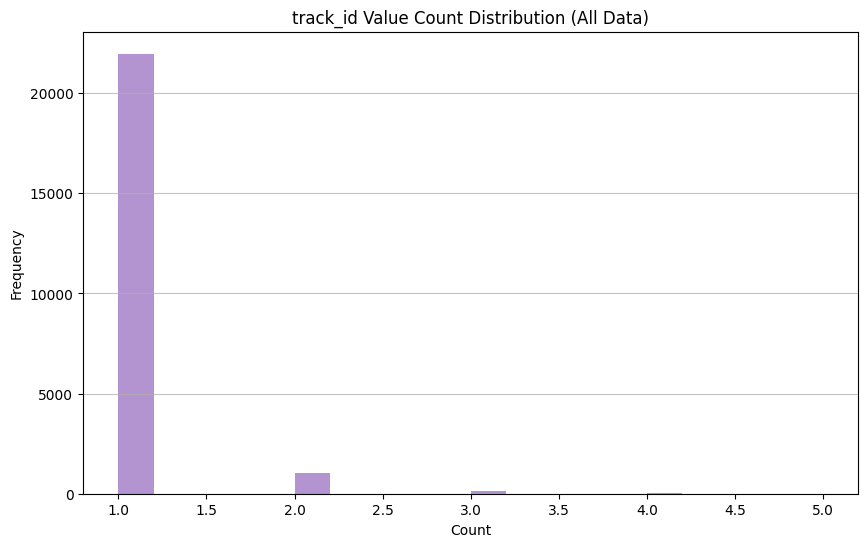

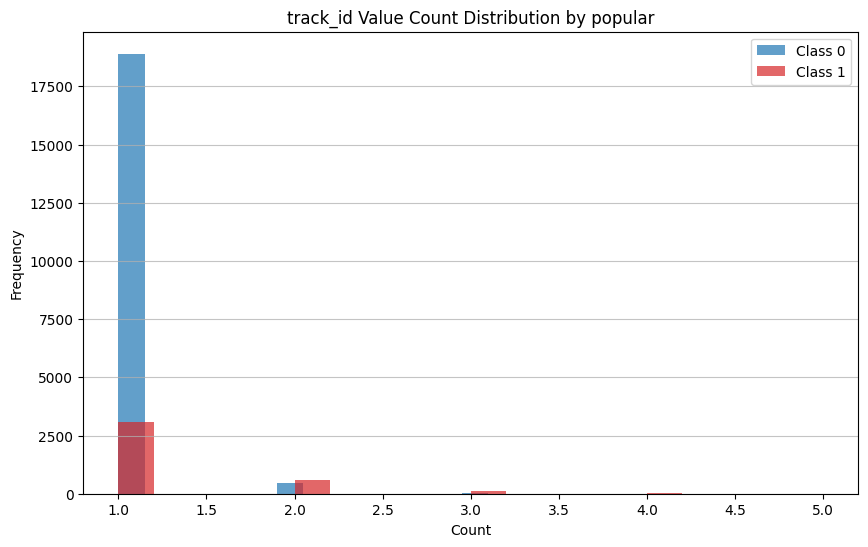

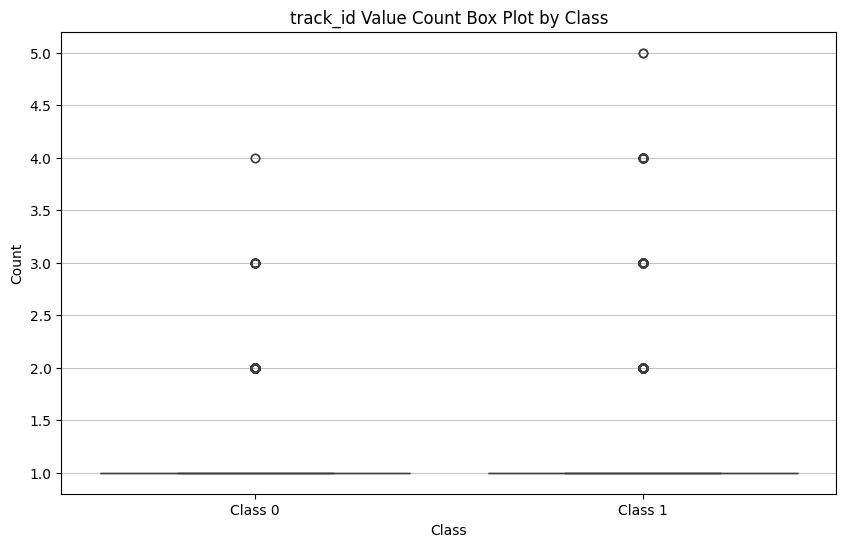

In [ ]:
plot_value_count_distribution(data_1, 'track_id', 'popular')

In [ ]:
track_id_vc = data_1['track_id'].value_counts()
track_id_vc

track_id
6mAN61JH0dzyZpWslS11jy    5
3eekarcy7kvN4yt5ZFzltW    5
7BKLCZ1jbUBVqRi2FVlTVw    5
0sf12qNH5qcw8qpgymFOqD    4
57vxBYXtHMk6H1aD29V7PU    4
                         ..
1Sgj10byiGzPpI2IrXSFEn    1
2x6hopxvQkOzZTBdEMyUO2    1
40LQiUUUKXVGyNs09lHVjW    1
0lG6QM1jjbbX5UUn3DPmrZ    1
0oWHLtxWeMJhmwxtrxhNK0    1
Name: count, Length: 23184, dtype: int64

###`track_name`

**Implication**

There are 19532 unique `track_name`, 23165 unique `track_id` and 26242 rows of data.

In [ ]:
#number of the unique track_name
print(data_1['track_name'].nunique())
#number of rows of data
print(data_1.shape[0])
#number of unique track_id
print(data_1['track_id'].nunique())

19547
24630
23184


### `track_artist`
**Implication**

Most artists in the dataset have only one track, and the majority never have a popular track. For an artist to have at least one popular track, they must be in the 83.2th percentile or above. The total number of tracks, whether popular or unpopular, is heavily skewed with a long tail. Some outliers have a significant number of popular tracks, while a few outliers stand out because every track they have is popular.

Interestingly, even among artists with popular tracks, the track popularity ratio (the proportion of popular tracks compared to their total tracks) tends to decrease as the number of tracks increases. This suggests that artists with a large catalog of tracks are less likely to maintain a high popularity ratio. Among popular artists with fewer than 20 tracks, the track popularity ratio is highly scattered.

In [ ]:
track_artist_df = compute_track_metrics(data_1, "track_artist", "popular")
track_artist_df

       total_tracks  popular_tracks  unpopular_tracks
count   9405.000000     9405.000000       9405.000000
mean       2.464753        0.405316          2.059436
std        4.235712        1.464921          3.411296
min        1.000000        0.000000          0.000000
25%        1.000000        0.000000          1.000000
50%        1.000000        0.000000          1.000000
75%        2.000000        0.000000          2.000000
max      103.000000       25.000000         90.000000


total_tracks  popular_tracks  unpopular_tracks
track_artist                                                             
David Guetta                         72              25                47
Bad Bunny                            32              24                 8
Ozuna                                32              23                 9
Drake                                61              23                38
Khalid                               26              22                 4
...                                 ...             ...               ...
Heavy D & The Boyz                   16               0                16
HeavensDust                           1               0                 1
Heaven 17                             1               0                 1
Heather Schnoor                       1               0                 1
落日飛車 Sunset Rollercoaster             1               0                 1

[9405 rows x 3 columns]

In [ ]:
# Filter the DataFrame for artists with at least one popular track
artists_with_popular_tracks = track_artist_df[track_artist_df['popular_tracks'] >= 1]

# Calculate the percentile of these artists relative to the total number of artists
percentile = (1-(len(artists_with_popular_tracks) / len(track_artist_df))) * 100

# Print the result
print(f"The percentile of artists with at least one popular track is: {percentile:.2f}%")


The percentile of artists with at least one popular track is: 83.21%


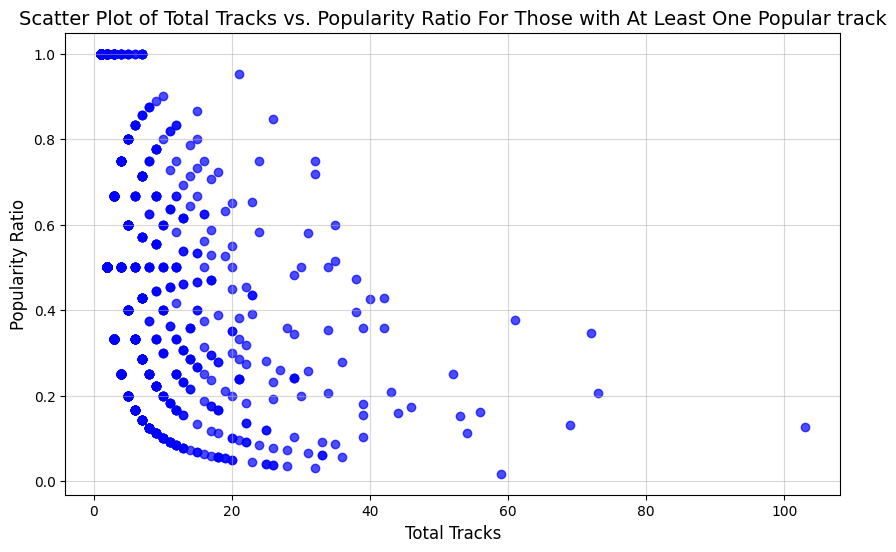

In [ ]:
#check the popularity ratio of those with at least one popular track
track_artist_df['popularity_ratio'] = track_artist_df['popular_tracks'] / track_artist_df['total_tracks']
high_ratio_artists = track_artist_df[track_artist_df['popularity_ratio'] > 0.001]
high_ratio_artists

plt.figure(figsize=(10, 6))
plt.scatter(high_ratio_artists['total_tracks'], high_ratio_artists['popularity_ratio'], alpha=0.7, color='blue')
plt.title("Scatter Plot of Total Tracks vs. Popularity Ratio For Those with At Least One Popular track", fontsize=14)
plt.xlabel("Total Tracks", fontsize=12)
plt.ylabel("Popularity Ratio", fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()


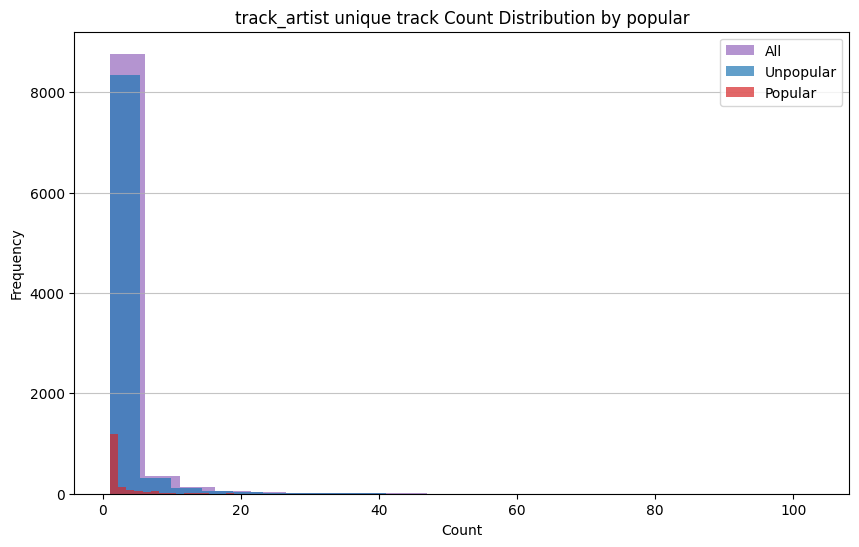

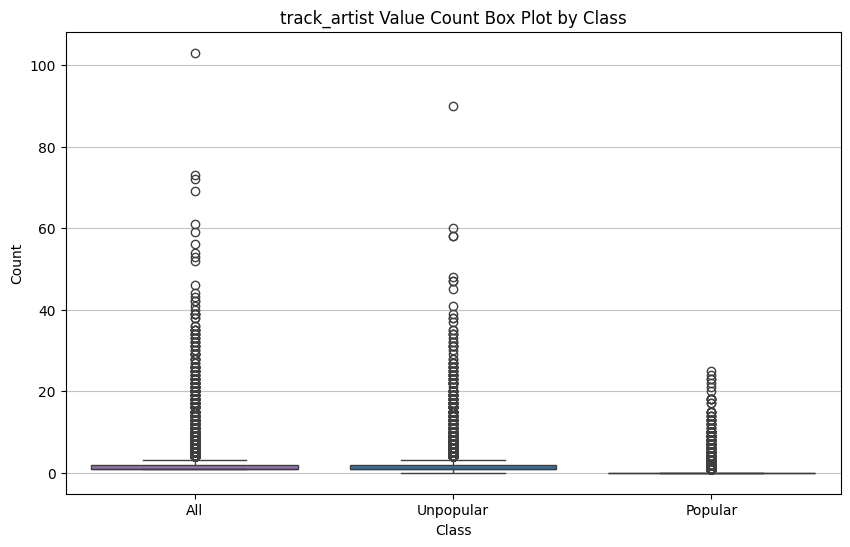

In [ ]:
plot_unique_track_count_distribution(data_1, "track_artist", "popular")

### `release_year`

**Changes**

Utilized the Spotify API to correct erroneous data and fill in missing values.

**Implication**

Most of the popular song are released recently

In [ ]:
data_1['release_year'].unique()

array(['2019', '1978', '2015', '2020', '2017', '2007', '2011', '2001',
       '2014', '2018', '2016', '2000', '2005', '1997', '1905', '2008',
       '2010', '2012', '1995', '2013', '2004', '1991', '2009', '1975',
       '1967', '2003', '1979', '2006', '1996', '1974', '1988', '1983',
       '1992', '1982', '1984', '1998', '1993', '1973', '1985', '2002',
       '1980', '1999', '1977', '1986', '1990', '1971', '1994', '1965',
       '1969', '1987', '1981', '1989', '1976', '1970', '1966', '1972',
       '#VALUE!', '1964', '1968', '1963', '1958', '1961', '1957'],
      dtype=object)

In [ ]:
data_1.replace('#VALUE!', np.nan, inplace=True)

In [ ]:
data_1['release_year'] = data_1['release_year'].fillna(0).astype(int)

# the data from 1905 is an error
data_1['release_year'].value_counts().sort_index().head(5)

release_year
0         21
1905    1360
1957       1
1958       1
1961       1
Name: count, dtype: int64

In [ ]:
# a closer look of the error data
data_1[data_1['release_year']==1905]['release_month'].value_counts()

release_month
6    936
5    215
7    209
Name: count, dtype: int64

In [ ]:
#show the amount of erroneous data
data_1[(data_1['release_year']==1905) | (data_1['release_year']==0)].shape

(1381, 19)

**use spotify api to correct data**

In [ ]:
'''This block of code uses the Spotify API to correct errors in the release year and month.
To prevent potential issues that might arise from repeatedly accessing the API, the corrected
results are saved as a CSV file after execution. In subsequent runs, the code will import the
saved results instead of re-fetching the data. If the corrected data is already available,
this block can be commented out to use the previously saved results directly.'''


# # Identify rows to check
# data_1['to_check'] = 0
# data_1.loc[(data_1['release_year'] == 1905) | (data_1['release_year'] == 0), 'to_check'] = 1

# # Set up the Spotify API credentials
# client_id = spotify_client_id
# client_secret = spotify_client_secret
# spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

# # Function to check similarity between track names and artists
# def is_alike(api_track_name, api_track_artist, df_track_name, df_track_artist):
#     """
#     Stricter match logic for track names and artists.
#     """
#     # Clean and normalize strings
#     def clean_string(s):
#         s = s.lower()
#         s = re.sub(r'[^\w\s]', '', s)  # Remove punctuation
#         s = re.sub(r'\s+', ' ', s).strip()  # Remove extra spaces
#         return s

#     api_track_name = clean_string(api_track_name)
#     api_track_artist = clean_string(api_track_artist)
#     df_track_name = clean_string(df_track_name)
#     df_track_artist = clean_string(df_track_artist)

#     # Use stricter similarity thresholds for both name and artist
#     name_similarity = SequenceMatcher(None, api_track_name, df_track_name).ratio()
#     artist_similarity = SequenceMatcher(None, api_track_artist, df_track_artist).ratio()

#     return name_similarity > 0.85 and artist_similarity > 0.85

# # Function to fetch release date
# def fetch_release_date_with_validation(track_id, track_name, track_artist):
#     try:
#         # Query Spotify API using track ID
#         track_data = spotify.track(track_id)
#         api_track_name = track_data['name']
#         api_track_artist = track_data['artists'][0]['name']
#         release_date = track_data['album']['release_date']

#         # Check if the track name and artist match
#         if is_alike(api_track_name, api_track_artist, track_name, track_artist):
#             # Parse release date (year, month)
#             year, month, *_ = release_date.split('-') + [None, None]
#             return int(year), int(month or 1)
#         else:
#             # Fallback to search by track name and artist if not alike
#             query = f"track:{track_name} artist:{track_artist}"
#             results = spotify.search(q=query, type='track', limit=1)
#             if results['tracks']['items']:
#                 fallback_track = results['tracks']['items'][0]
#                 release_date = fallback_track['album']['release_date']
#                 year, month, *_ = release_date.split('-') + [None, None]
#                 return int(year), int(month or 1)
#     except Exception as e:
#         print(f"Error fetching data for {track_name} by {track_artist}: {e}")
#     return None, None

# # Update the DataFrame
# for index, row in data_1.iterrows():
#     if row['to_check'] == 1:
#         year, month = fetch_release_date_with_validation(row['track_id'], row['track_name'], row['track_artist'])
#         if year and month:
#             data_1.at[index, 'release_year'] = year
#             data_1.at[index, 'release_month'] = month

# # Drop temporary column and save the updated DataFrame
# data_1.drop(columns=['to_check'], inplace=True)
# data_1.to_csv('DSO528_project_spotify_1_corrected_temp1.csv', index=False)


'This block of code uses the Spotify API to correct errors in the release year and month.\nTo prevent potential issues that might arise from repeatedly accessing the API, the corrected\nresults are saved as a CSV file after execution. In subsequent runs, the code will import the\nsaved results instead of re-fetching the data. If the corrected data is already available,\nthis block can be commented out to use the previously saved results directly.'

In [ ]:
data_1 = pd.read_csv('DSO528_project_spotify_1_corrected_temp1.csv')
data_1

track_id                     track_name    track_artist  \
0      697MjF1454XKvZmTuqkWmD                     I Miss You          Jeriqo   
1      3x2bXiU0o4WbsPkawXlfDA                    Who Are You         The Who   
2      0jEaPBjFAWjQTMVouRwaHi                          Happy  The Beef Seeds   
3      5EKUb1FKsyYVaSXb41YBIj                            ONE      Rev Theory   
4      300DUx4tdtCdGEUXR032jA                   Palace/Curse    The Internet   
...                       ...                            ...             ...   
24625  6bE9Ud8C8stzPwu7xJRx9u                          Tokyo           Drevm   
24626  29ikXeGM6kScvhvqfvgiwO                  Drunken Truth      Steve Void   
24627  47zREtxQZ3cHHIZwUQnuuN  Never Be Like You (feat. Kai)           Flume   
24628  61swngFBghaxXM0YT7CDU1        Symphony - Original Mix    Sandro Silva   
24629  0oWHLtxWeMJhmwxtrxhNK0          Welcome To The Jungle   Guns N' Roses   

       popular  release_year  release_month playlist_genre  danceability  \
0            0          2019              2            edm         0.520   
1            0          1978              8           rock         0.651   
2            0          2015              1            r&b         0.640   
3            0          2020              1           rock         0.398   
4            0          2015              6            r&b         0.447   
...        ...           ...            ...            ...           ...   
24625        0          2019             12            rap         0.715   
24626        0          2019             12            pop         0.781   
24627        0          2016              5            edm         0.564   
24628        0          2014              8            edm         0.545   
24629        0          1987              1           rock         0.443   

       energy  key  loudness  mode  speechiness  acousticness  \
0       0.789    0    -7.717     1       0.0432      0.004910   
1       0.661    9   -11.405     1       0.0511      0.265000   
2       0.758   10    -5.204     1       0.1600      0.665000   
3       0.966    4    -2.352     0       0.0453      0.000006   
4       0.625   10    -8.212     0       0.3230      0.035100   
...       ...  ...       ...   ...          ...           ...   
24625   0.349    0   -10.519     1       0.2510      0.732000   
24626   0.745    1    -4.942     0       0.0374      0.081400   
24627   0.552    0    -5.438     1       0.0550      0.439000   
24628   0.774    0    -3.689     1       0.0440      0.001480   
24629   0.955    8    -8.066     1       0.0741      0.022200   

       instrumentalness  liveness  valence    tempo  duration_ms  
0              0.000013    0.0816    0.415  174.026       216347  
1              0.003130    0.1060    0.489  156.371       378707  
2              0.000000    0.1270    0.932   86.529       218044  
3              0.000000    0.3030    0.520   90.016       208196  
4              0.000727    0.2430    0.261   67.104       440013  
...                 ...       ...      ...      ...          ...  
24625          0.715000    0.0725    0.406   85.302       101295  
24626          0.000097    0.1060    0.498  110.051       158091  
24627          0.000000    0.1630    0.260  119.907       233337  
24628          0.933000    0.5590    0.212  128.026       301890  
24629          0.361000    0.2970    0.333  123.423       273600  

[24630 rows x 19 columns]

In [ ]:
#the remaining lines of error data is only 113
data_1[(data_1['release_year']==1905) | (data_1['release_year']==0)].shape[0]

24

In [ ]:
#drop the remaining errorenous data
data_1 = data_1[(data_1['release_year'] != 1905) & (data_1['release_year'] != 0)].reset_index(drop=True)

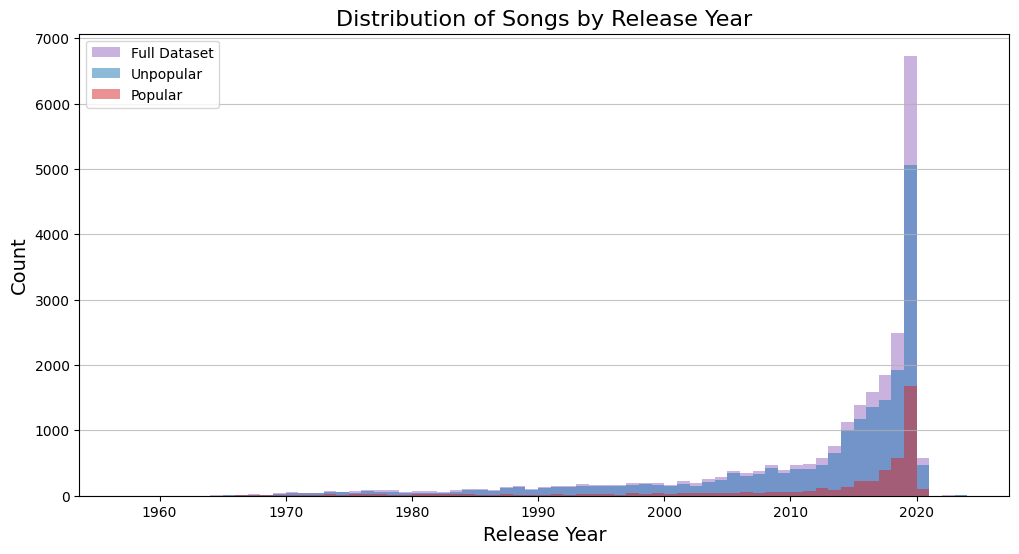

In [ ]:
# Define bins for consistent visualization
bins = range(data_1['release_year'].min(), data_1['release_year'].max() + 1)

# Get the data subsets
full_data = data_1['release_year']
popular_0 = data_1[data_1['popular'] == 0]['release_year']
popular_1 = data_1[data_1['popular'] == 1]['release_year']

# Plot overlapping histograms
plt.figure(figsize=(12, 6))
plt.hist(full_data, bins=bins, alpha=0.5, label='Full Dataset', color= plt.colormaps.get_cmap('tab20')(8))
plt.hist(popular_0, bins=bins, alpha=0.5, label='Unpopular', color=plt.colormaps.get_cmap('tab20')(0))
plt.hist(popular_1, bins=bins, alpha=0.5, label='Popular', color=plt.colormaps.get_cmap('tab20')(6))

# Add titles and labels
plt.title('Distribution of Songs by Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Show plot
plt.show()


### `release_month`
**Changes**

Utilized the Spotify API to correct some values in the release_month column for improved accuracy. Dropped rows with missing release month information.

**Implication**

A disproportionately high number of releases in January remains even after corrections, indicating potential data anomalies or trends.

In [ ]:
data_1['release_month'] = data_1['release_month'].astype(int)

In [ ]:
# Lots of data release on Janurary
# suspect data error since Janurary is not considered as prime release period
data_1['release_month'].value_counts()

release_month
1     4734
11    2591
10    2343
9     1961
6     1861
12    1828
8     1740
5     1700
3     1557
7     1550
4     1486
2     1255
Name: count, dtype: int64

In [ ]:
# '''
# This block of code uses the Spotify API to correct errors in the release month.
# Rows where the release_month is `1` are flagged as needing correction (`to_check` = 1).
# For flagged rows, the Spotify API is used to fetch the correct month. If Spotify
# returns a valid month, the release month is updated. If not, the release month
# is set to `0`. The corrected results are saved as a CSV file to avoid redundant
# API calls in subsequent runs.
# '''


# #Check track with release_month ==1
# # left out those with same track_name and track_artist combination but different track_id
# data_1['to_check'] = (data_1['release_month'] == 1).astype(int)
# unique_combinations = data_1.groupby(['track_name', 'track_artist'])['track_id'].nunique()
# conflicting_combinations = unique_combinations[unique_combinations > 1].index
# data_1.loc[
#     data_1.set_index(['track_name', 'track_artist']).index.isin(conflicting_combinations)
#     & (data_1['release_month'] == 1),
#     'to_check'
# ] = 0

# # Set up the Spotify API credentials
# client_id = spotify_client_id
# client_secret = spotify_client_secret
# spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

# # Function to fetch release date using Spotify API
# def fetch_release_date(track_name, track_artist):
#     try:
#         query = f"track:{track_name} artist:{track_artist}"
#         results = spotify.search(q=query, type='track', limit=1)
#         if results['tracks']['items']:
#             release_date = results['tracks']['items'][0]['album']['release_date']
#             year, month, *_ = release_date.split('-') + [None, None]  # Add placeholders for missing month/day
#             return int(year), int(month or 0)
#     except Exception as e:
#         print(f"Error fetching data for {track_name} by {track_artist}: {e}")
#     return None, None

# # Iterate through rows and update release_month if needed
# for index, row in data_1.iterrows():
#     if row['to_check'] == 1:
#         year, month = fetch_release_date(row['track_name'], row['track_artist'])
#         if year and month:  # Update only if both year and month are valid
#             data_1.at[index, 'release_year'] = year
#             data_1.at[index, 'release_month'] = month
#         else:
#             data_1.at[index, 'release_month'] = 0  # Set to 0 if Spotify cannot find the proper month

# # Drop the 'to_check' column after processing
# data_1.drop(columns=['to_check'], inplace=True)

# # Save the corrected results to a CSV file
# data_1.to_csv('DSO528_project_spotify_1_corrected_temp2.csv', index=False)


In [ ]:
data_1 = pd.read_csv('DSO528_project_spotify_1_corrected_temp2.csv')

In [ ]:
#Identify 841 track with no avalible track month data
data_1['release_month'].value_counts()

release_month
1     3180
11    2704
10    2426
9     2012
6     1912
12    1871
8     1791
5     1756
3     1623
7     1612
4     1539
2     1339
0      841
Name: count, dtype: int64

In [ ]:
# Replace "0" and 0 with 1 in the 'release_month' column
# for easy to run purpose, we also change it back to januarary as the default
data_1['release_month'] = data_1['release_month'].replace(["0", 0], 1)


In [ ]:
data_1['release_month'].value_counts()

release_month
1     4021
11    2704
10    2426
9     2012
6     1912
12    1871
8     1791
5     1756
3     1623
7     1612
4     1539
2     1339
Name: count, dtype: int64

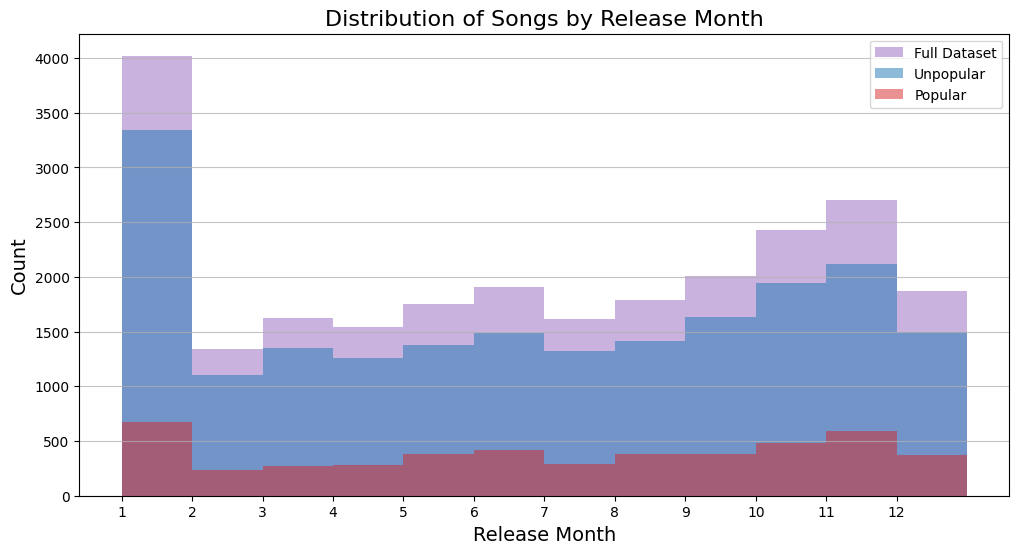

In [ ]:
# Define bins for consistent visualization (1 to 12 for months)
bins = range(1, 14)  # Adding 13 because the upper limit in range is exclusive

# Get the data subsets
full_data = data_1['release_month'].sort_values()
popular_0 = data_1[data_1['popular'] == 0]['release_month'].sort_values()
popular_1 = data_1[data_1['popular'] == 1]['release_month'].sort_values()

# Plot overlapping histograms
plt.figure(figsize=(12, 6))
plt.hist(full_data, bins=bins, alpha=0.5, label='Full Dataset', color=plt.colormaps.get_cmap('tab20')(8))
plt.hist(popular_0, bins=bins, alpha=0.5, label='Unpopular', color=plt.colormaps.get_cmap('tab20')(0))
plt.hist(popular_1, bins=bins, alpha=0.5, label='Popular', color=plt.colormaps.get_cmap('tab20')(6))

# Add titles and labels
plt.title('Distribution of Songs by Release Month', fontsize=16)
plt.xlabel('Release Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(1, 13))  # Ensure x-axis ticks are labeled as months
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Show plot
plt.show()

### `date` (new column)
**Changes**

To enhance our analysis, we will create a new column, `date`, combining the release year and month into a `datetime` object. This transformation provides a more structured and efficient way to analyze temporal data.

**Implication**

We observe strong seasonality in the data prior to 2013, which seems to disappear abruptly afterward. One hypothesis is that many historical records within the Spotify database, accessed through the API and other data sources, default to January as the release month when only the release year is available. This lack of granularity in older data may have artificially introduced seasonality. After 2013, as data quality improved and more precise release dates became available, the seasonality caused by data errors and handling practices appears to have diminished.

In [ ]:
data_1['release_year'] = data_1['release_year'].astype(str)
data_1['release_month'] = data_1['release_month'].astype(str)


#make a datetime object for easy analysis later
data_1['date'] = data_1['release_year'] + "-" + data_1['release_month']
data_1['date'] = pd.to_datetime(data_1['date'], format='%Y-%m')

#change the year and month to in for easy analysis later
data_1['release_year'] = data_1['release_year'].astype(int)
data_1['release_month'] = data_1['release_month'].astype(int)


In [ ]:
data_1[data_1['date'] >= "2020-02-01"].shape

(237, 20)

In [ ]:
#to be consistent with the fact that the data is extracted before may 2020
#drop columns that data is larger than may 2020 due to conflict in dataset and spotify
data_1 = data_1[data_1['date'] < "2020-02-01"].reset_index(drop=True)

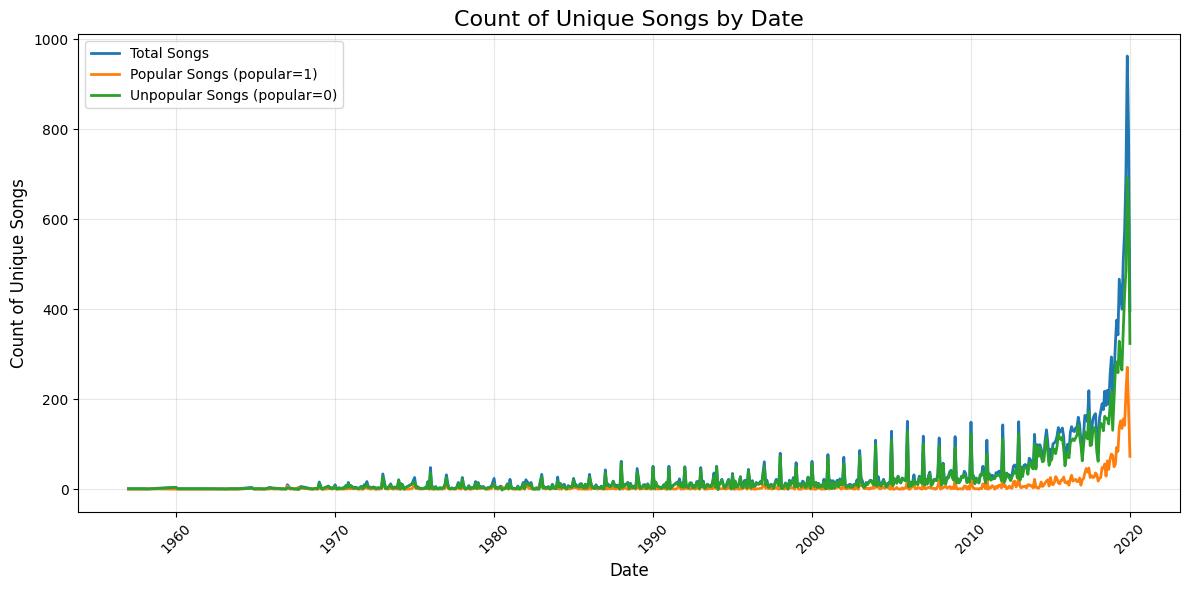

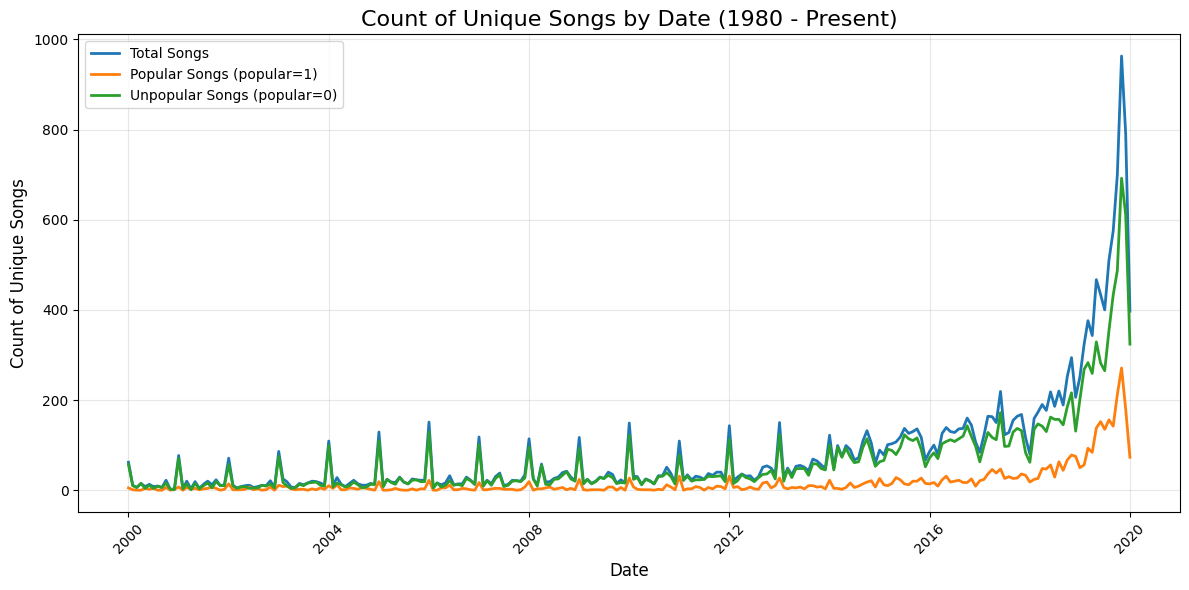

In [ ]:
# Group by date and calculate counts
counts = data_1.groupby('date').agg(
    total_songs=('track_id', 'nunique'),  # Count unique track_id for all songs
    popular_songs=('track_id', lambda x: data_1.loc[x.index, 'popular'].eq(1).sum()),  # Count unique popular track_id
)
# Calculate unpopular songs as total_songs - popular_songs
counts['unpopular_songs'] = counts['total_songs'] - counts['popular_songs']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(counts.index, counts['total_songs'], label='Total Songs', linewidth=2)
plt.plot(counts.index, counts['popular_songs'], label='Popular Songs (popular=1)', linewidth=2)
plt.plot(counts.index, counts['unpopular_songs'], label='Unpopular Songs (popular=0)', linewidth=2)

# Customizing the plot
plt.title('Count of Unique Songs by Date', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count of Unique Songs', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Filter data for zoomed range (1980 to present)
zoomed_counts = counts.loc[counts.index >= '2000-01-01']

# Zoomed plot
plt.figure(figsize=(12, 6))
plt.plot(zoomed_counts.index, zoomed_counts['total_songs'], label='Total Songs', linewidth=2)
plt.plot(zoomed_counts.index, zoomed_counts['popular_songs'], label='Popular Songs (popular=1)', linewidth=2)
plt.plot(zoomed_counts.index, zoomed_counts['unpopular_songs'], label='Unpopular Songs (popular=0)', linewidth=2)
plt.title('Count of Unique Songs by Date (1980 - Present)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count of Unique Songs', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
data_1['release_year'].value_counts().sort_index()

release_year
1957       2
1958       2
1960       5
1961       1
1962       2
1963       3
1964       5
1965      12
1966      10
1967      27
1968      13
1969      41
1970      59
1971      51
1972      50
1973      75
1974      61
1975      72
1976      91
1977      82
1978      83
1979      54
1980      76
1981      69
1982      61
1983      86
1984     107
1985     102
1986      91
1987     140
1988     151
1989     100
1990     130
1991     153
1992     151
1993     183
1994     175
1995     166
1996     170
1997     193
1998     203
1999     193
2000     169
2001     220
2002     184
2003     257
2004     279
2005     356
2006     338
2007     359
2008     442
2009     384
2010     468
2011     476
2012     563
2013     737
2014    1127
2015    1392
2016    1587
2017    1857
2018    2490
2019    6736
2020     447
Name: count, dtype: int64

###  `playlist_genre`

**Implication**

The dataset contains a total of six genres, ranked by popularity as follows: `pop`, `latin`, `r&b`, `rock`, `rap` and `edm`. Most songs in the dataset are associated with only one genre. Interestingly, songs with multiple genre labels tend to be more likely classified as popular. However, it remains unclear whether this is a causal relationship or merely a correlation. Further analysis would be required to determine the underlying dynamics.

In [ ]:
# Get the counts for all, popular, and unpopular playlist genres
playlist_genre_all = data_1['playlist_genre'].value_counts()
playlist_genre_popular = data_1[data_1['popular'] == 1]['playlist_genre'].value_counts()
playlist_genre_unpopular = data_1[data_1['popular'] == 0]['playlist_genre'].value_counts()

# Combine into one DataFrame
playlist_genre_df = pd.DataFrame({
    'Total': playlist_genre_all,
    'Popular': playlist_genre_popular,
    'Unpopular': playlist_genre_unpopular,
    'Popular Ratio': (playlist_genre_popular / playlist_genre_all)
}).fillna(0)  # Fill NaN with 0 and convert to integer

# Format the "Popular Ratio" as a percentage
playlist_genre_df['Popular Ratio'] = (playlist_genre_df['Popular Ratio'] * 100).map('{:.2f}%'.format)

# Sort the DataFrame by the Total column
playlist_genre_df = playlist_genre_df.sort_values(by='Popular', ascending=False)

# Display the resulting DataFrame
playlist_genre_df


Total  Popular  Unpopular Popular Ratio
playlist_genre                                         
pop              4099     1124       2975        27.42%
latin            3756      911       2845        24.25%
r&b              4098      804       3294        19.62%
rap              4415      723       3692        16.38%
rock             3567      693       2874        19.43%
edm              4434      455       3979        10.26%

In [ ]:
data_1.columns

Index(['track_id', 'track_name', 'track_artist', 'popular', 'release_year',
       'release_month', 'playlist_genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'date'],
      dtype='object')

In [ ]:
# Group by track_id and calculate the number of unique genres
genre_count_per_track = data_1.groupby('track_id').agg(
    unique_genres=('playlist_genre', 'nunique'),
    popularity=('popular', 'first')  # Assuming popularity is consistent per track_id
).reset_index()

# Calculate the distribution of genres for all songs
all_genre_distribution = genre_count_per_track['unique_genres'].value_counts().sort_index()

# Calculate the distribution of genres for popular songs
popular_genre_distribution = genre_count_per_track[genre_count_per_track['popularity'] == 1]['unique_genres'].value_counts().sort_index()

# Calculate the distribution of genres for unpopular songs
unpopular_genre_distribution = genre_count_per_track[genre_count_per_track['popularity'] == 0]['unique_genres'].value_counts().sort_index()

# Combine the distributions into a single DataFrame
genre_distribution_df = pd.DataFrame({
    'All Songs': all_genre_distribution,
    'Popular Songs': popular_genre_distribution,
    'Unpopular Songs': unpopular_genre_distribution,
    'Popular Ratio': (popular_genre_distribution / all_genre_distribution)
    }).fillna(0)

genre_distribution_df.sort_values(by='Popular Ratio', ascending = False, inplace=True)
# Display the resulting DataFrame
genre_distribution_df


All Songs  Popular Songs  Unpopular Songs  Popular Ratio
unique_genres                                                          
5                      3              3              0.0       1.000000
4                     45             43              2.0       0.955556
3                    131            106             25.0       0.809160
2                   1016            581            435.0       0.571850
1                  21749           3043          18706.0       0.139914

### `danceability`

**Implication**
This variable exhibits a right skewed distribution, with the mean centered around 0.65. Higher danceability values, particularly in the range of 0.5 to 0.9, appear to correspond to a greater proportion of popular songs.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean       0.653979      0.667782      0.651260
std        0.145692      0.148600      0.144962
min        0.000000      0.135000      0.000000
25%        0.562000      0.570750      0.561000
50%        0.671000      0.685000      0.668000
75%        0.760000      0.776000      0.756000
max        0.983000      0.979000      0.983000


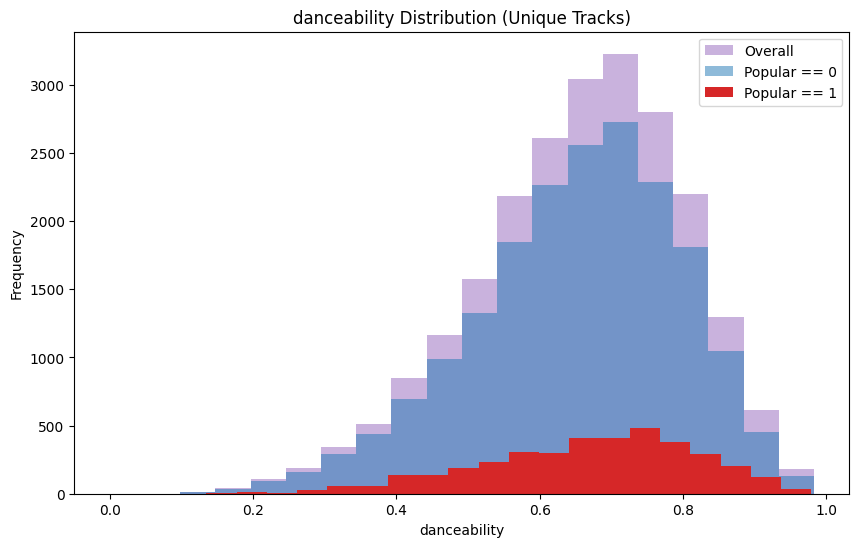

<Figure size 800x600 with 0 Axes>

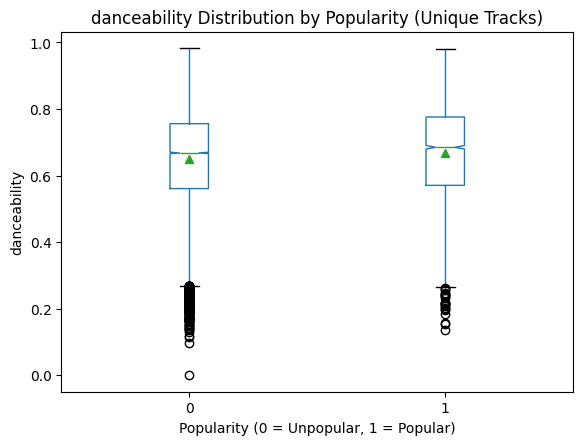

In [ ]:
analyze_column_distribution_continuous(data_1, 'danceability')

### `energy`

**Implication**

The distribution is heavily right skewed; however, the energy levels of popular songs appear to exhibit less right skewness compared to the overall sample.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean       0.697928      0.676354      0.702178
std        0.183383      0.170570      0.185512
min        0.008140      0.016700      0.008140
25%        0.579000      0.564000      0.582000
50%        0.722000      0.698000      0.727000
75%        0.842000      0.801000      0.849000
max        1.000000      0.991000      1.000000


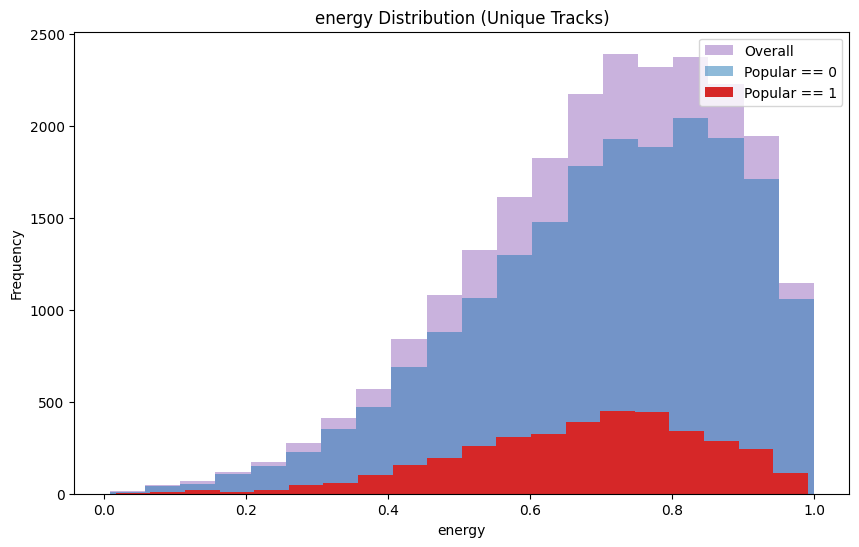

<Figure size 800x600 with 0 Axes>

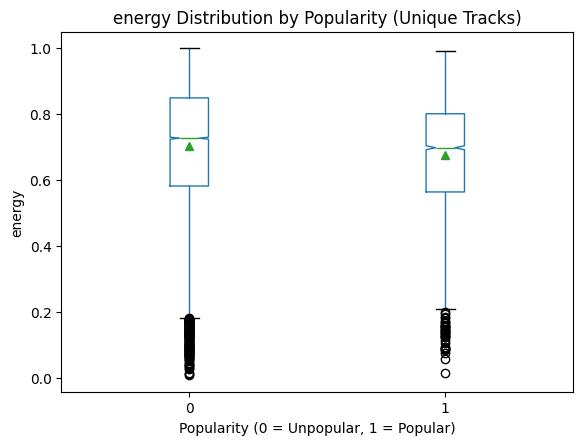

In [ ]:

analyze_column_distribution_continuous(data_1, 'energy')

### `key`

**Implication**
The distribution shows that Key 0 (C), Key 1 (C#/Db), and Key 7 (G) are the most common, especially in popular tracks. These keys are versatile, emotionally resonant, and easy to compose with, which aligns with listener preferences. Less common keys like Key 3 (D#/Eb) and Key 10 (A#/Bb) are likely underrepresented due to their complexity and niche applications. Popular tracks favor keys that are harmonically stable and widely appealing.

**Explanation of the Distribution of Keys in Music**

The distribution of keys for all tracks, popular tracks, and unpopular tracks highlights some trends, considering the numeric representation of musical keys:

---

1. **General Trends**
- **Key 0 (C Major/Minor)** and **Key 1 (C#/Db Major/Minor)** are the most frequent keys overall. These keys are easier to compose in, especially on instruments like the piano (e.g., C Major has no sharps or flats).
- Keys such as **3 (D#/Eb)** and **10 (A#/Bb)** are less frequent. Their complexity makes them less commonly used in mainstream music.

---

2. **Distribution in Popular Tracks**
- **Key 1 (C#/Db)**, **Key 0 (C)**, and **Key 7 (G)** dominate among popular tracks, likely due to their tonal stability and emotional versatility.
- **Key 3 (D#/Eb)** and **Key 8 (G#/Ab)** are underrepresented in popular tracks, as they are harder to work with musically.

---

3. **Unpopular Tracks**
- The distribution of keys in unpopular tracks is similar to the overall trend but shows fewer occurrences of **Key 1 (C#/Db)** and **Key 7 (G)**, suggesting these keys align with characteristics of popular songs.

---

4. **Musical Context of Keys**
- **Key 0 (C Major/Minor)**: Simple, versatile, and neutral; widely used.
- **Key 1 (C#/Db Major/Minor)**: Dramatic and emotional, commonly used for striking compositions.
- **Key 7 (G Major/Minor)**: Bright and uplifting in Major; emotional in Minor.
- **Key 3 (D#/Eb)** and **Key 10 (A#/Bb)**: More complex and niche, less common in mainstream music.

---

5. **Why Certain Keys Are More Popular**
- **Ease of Instrumentation**: Keys like C, G, and F are easier for guitarists and pianists to play.
- **Listener Appeal**: C Major and G Major align with common chord progressions, making them universally relatable.
- **Production Preferences**: Keys that are easy to harmonize or remix are favored in modern music production.

---

Key Takeaways
- Popular tracks favor **Key 0 (C)**, **Key 1 (C#/Db)**, and **Key 7 (G)** for their emotional resonance, versatility, and ease of use.
- Complex keys like **Key 3 (D#/Eb)** and **Key 10 (A#/Bb)** are less frequent due to their technical challenges.
- The trends reflect how technical ease and emotional impact shape the choice of keys in popular music.

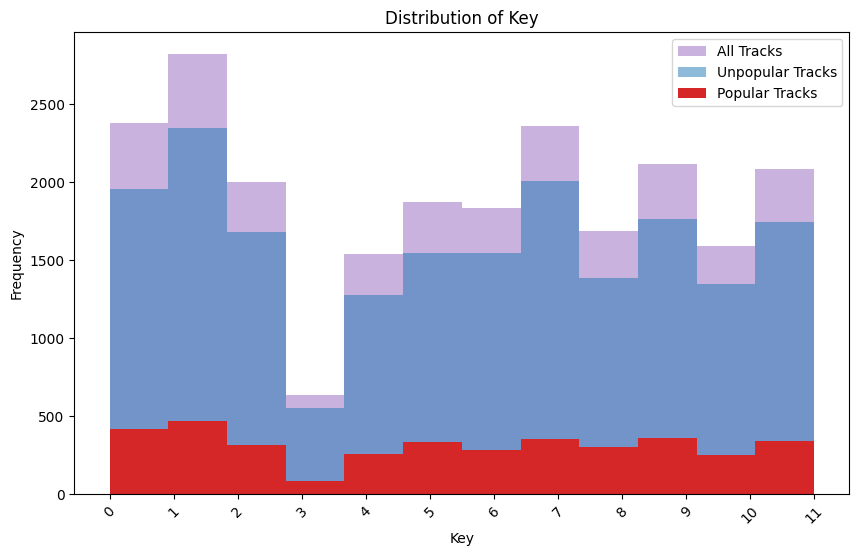

<Figure size 800x600 with 0 Axes>

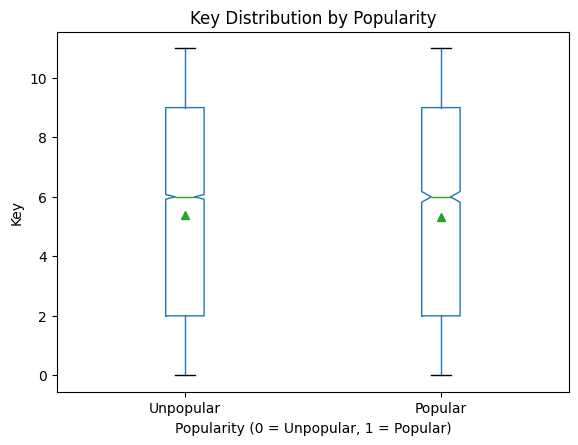

All Tracks  Popular Tracks  Unpopular Tracks  Popular Ratio
key                                                             
8          1689             305              1384       0.180580
5          1876             332              1544       0.176972
0          2378             418              1960       0.175778
9          2120             358              1762       0.168868
4          1539             259              1280       0.168291
1          2821             471              2350       0.166962
11         2088             340              1748       0.162835
2          2003             319              1684       0.159261
6          1835             287              1548       0.156403
10         1594             249              1345       0.156211
7          2363             352              2011       0.148963
3           638              86               552       0.134796

In [ ]:
key_distribution = calculate_categorical_distribution(data_1, 'key')
key_distribution


In [ ]:
data_1

track_id                     track_name    track_artist  \
0      697MjF1454XKvZmTuqkWmD                     I Miss You          Jeriqo   
1      3x2bXiU0o4WbsPkawXlfDA                    Who Are You         The Who   
2      0jEaPBjFAWjQTMVouRwaHi                          Happy  The Beef Seeds   
3      5EKUb1FKsyYVaSXb41YBIj                            ONE      Rev Theory   
4      300DUx4tdtCdGEUXR032jA                   Palace/Curse    The Internet   
...                       ...                            ...             ...   
24364  6bE9Ud8C8stzPwu7xJRx9u                          Tokyo           Drevm   
24365  29ikXeGM6kScvhvqfvgiwO                  Drunken Truth      Steve Void   
24366  47zREtxQZ3cHHIZwUQnuuN  Never Be Like You (feat. Kai)           Flume   
24367  61swngFBghaxXM0YT7CDU1        Symphony - Original Mix    Sandro Silva   
24368  0oWHLtxWeMJhmwxtrxhNK0          Welcome To The Jungle   Guns N' Roses   

       popular  release_year  release_month playlist_genre  danceability  \
0            0          2019              2            edm         0.520   
1            0          1978              8           rock         0.651   
2            0          2015              1            r&b         0.640   
3            0          2020              1           rock         0.398   
4            0          2015              6            r&b         0.447   
...        ...           ...            ...            ...           ...   
24364        0          2019             12            rap         0.715   
24365        0          2019             12            pop         0.781   
24366        0          2016              5            edm         0.564   
24367        0          2014              8            edm         0.545   
24368        0          1987              1           rock         0.443   

       energy  key  loudness  mode  speechiness  acousticness  \
0       0.789    0    -7.717     1       0.0432      0.004910   
1       0.661    9   -11.405     1       0.0511      0.265000   
2       0.758   10    -5.204     1       0.1600      0.665000   
3       0.966    4    -2.352     0       0.0453      0.000006   
4       0.625   10    -8.212     0       0.3230      0.035100   
...       ...  ...       ...   ...          ...           ...   
24364   0.349    0   -10.519     1       0.2510      0.732000   
24365   0.745    1    -4.942     0       0.0374      0.081400   
24366   0.552    0    -5.438     1       0.0550      0.439000   
24367   0.774    0    -3.689     1       0.0440      0.001480   
24368   0.955    8    -8.066     1       0.0741      0.022200   

       instrumentalness  liveness  valence    tempo  duration_ms       date  
0              0.000013    0.0816    0.415  174.026       216347 2019-02-01  
1              0.003130    0.1060    0.489  156.371       378707 1978-08-01  
2              0.000000    0.1270    0.932   86.529       218044 2015-01-01  
3              0.000000    0.3030    0.520   90.016       208196 2020-01-01  
4              0.000727    0.2430    0.261   67.104       440013 2015-06-01  
...                 ...       ...      ...      ...          ...        ...  
24364          0.715000    0.0725    0.406   85.302       101295 2019-12-01  
24365          0.000097    0.1060    0.498  110.051       158091 2019-12-01  
24366          0.000000    0.1630    0.260  119.907       233337 2016-05-01  
24367          0.933000    0.5590    0.212  128.026       301890 2014-08-01  
24368          0.361000    0.2970    0.333  123.423       273600 1987-01-01  

[24369 rows x 20 columns]

### `loudness`

**Implication**

The distribution shows that most tracks cluster around a loudness level between -8 dB and -4 dB. Popular tracks (red) tend to have slightly higher loudness compared to unpopular tracks (blue).

In Spotify datasets, **loudness** refers to the overall perceived volume or intensity of a track. It is measured in **decibels (dB)**, which is a logarithmic unit used to quantify sound levels. Loudness is not the same as peak volume; instead, it represents the **average loudness** of the track across its entirety.

Key Characteristics:

- **Measurement**:
  - Loudness values are typically negative because they are relative to a reference level (0 dB represents the maximum possible loudness). Tracks with a value closer to 0 are louder, while those with more negative values are quieter.
  - For example:
    - A loud rock track might have a loudness value of **-5 dB**.
    - A soft classical piece might have a loudness value of **-20 dB**.

- **Purpose**:
  - This feature helps normalize playback volume for users, ensuring consistency across tracks in a playlist or album.
  - It also aids in analyzing the dynamic range and production style of a track.

- **Relevance to Genres**:
  - Different genres tend to have distinct loudness profiles:
    - **EDM, Pop, and Rock**: Generally louder with values closer to 0 dB, as they are produced for maximum impact and energy.
    - **Jazz, Classical, and Acoustic**: Typically quieter with lower loudness values to preserve dynamic range and subtlety.

- **Applications**:
  - **Playlists**: Used for balancing volume across tracks in curated playlists.
  - **Audio Analysis**: Helps in identifying trends in production, such as the "loudness war," where tracks are mastered louder for greater impact.
  - **User Preferences**: Assists in matching songs to user preferences for energy and mood.

Example:

If the loudness value for a song is **-7 dB**, it is significantly louder than a track with **-15 dB**. However, both may still be within the acceptable range for comfortable listening, depending on the context and genre.


Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean      -6.809521     -6.324279     -6.905111
std        3.037761      2.697633      3.091466
min      -46.448000    -28.309000    -46.448000
25%       -8.294000     -7.505000     -8.448000
50%       -6.253000     -5.832000     -6.348500
75%       -4.697000     -4.519750     -4.738000
max        0.642000     -0.882000      0.642000


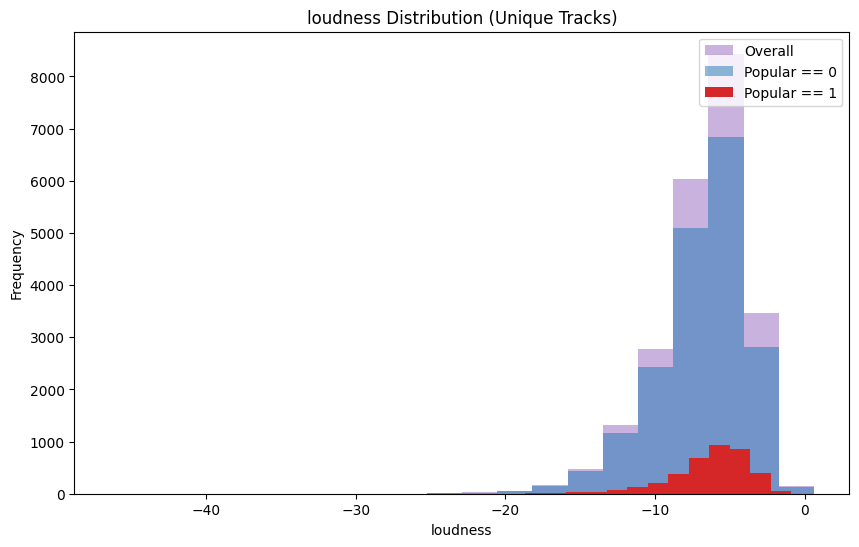

<Figure size 800x600 with 0 Axes>

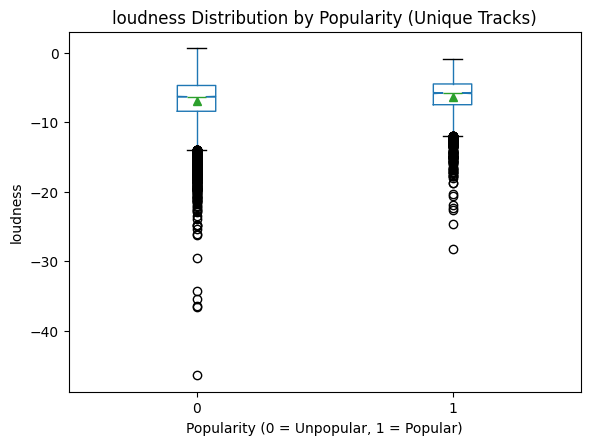

In [ ]:
analyze_column_distribution_continuous(data_1, 'loudness')

### `mode`

**Implication**

More song is in mode == 1 (major mode?)

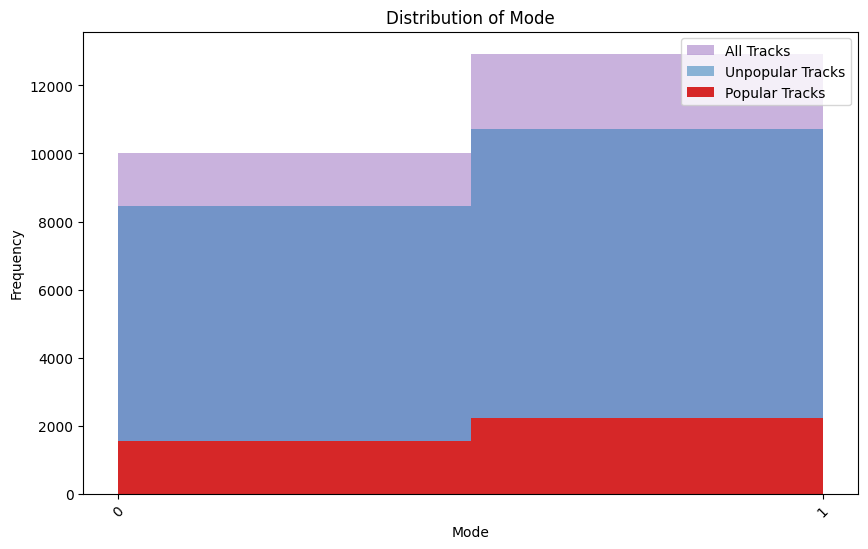

<Figure size 800x600 with 0 Axes>

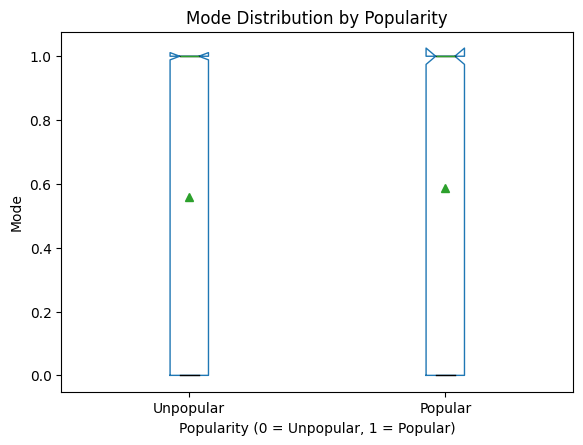

      All Tracks  Popular Tracks  Unpopular Tracks  Popular Ratio
mode                                                             
1          12939            2222             10717       0.171729
0          10005            1554              8451       0.155322


In [ ]:

# Example usage
mode_distribution = calculate_categorical_distribution(data_1, 'mode')  # Replace 'key' with any categorical column
print(mode_distribution)


### `key_mode`(new column)

**Changes**

Combining key and mode, the new column directly represents the full tonal identity of the track (e.g., C Major vs. C Minor), which can influence analyses such as popularity trends.

**Implication**

Some key and mode combinations are more frequently used than others, but the combinations with the highest popularity ratios are not necessarily the most common ones. For example, the combination "11_1" (Key 11 in major mode) has the highest popularity ratio of 0.201, yet it is less common compared to combinations like "1_1" (Key 1 in major mode) or "0_1" (Key 0 in major mode), which appear more frequently but have lower popularity ratios.

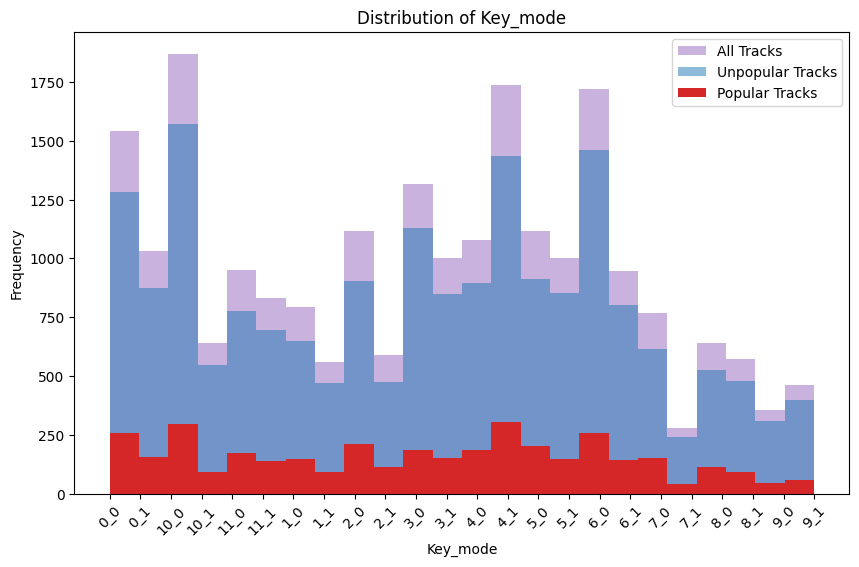

          All Tracks  Popular Tracks  Unpopular Tracks  Popular Ratio
key_mode                                                             
11_1             770             153               617       0.198701
4_1              591             114               477       0.192893
8_1             1117             212               905       0.189794
5_1              796             147               649       0.184673
9_1             1118             205               913       0.183363
1_0              952             173               779       0.181723
0_0              639             113               526       0.176839
0_1             1739             305              1434       0.175388
5_0             1080             185               895       0.171296
2_1             1542             259              1283       0.167964
6_1              834             139               695       0.166667
10_1             561              92               469       0.163993
8_0              572

In [ ]:
data_1['key_mode'] = data_1['key'].astype(str) + '_' + data_1['mode'].astype(str)
key_mode_distribution = calculate_categorical_distribution(data_1, 'key_mode')  # Replace 'key' with any categorical column
print(key_mode_distribution)



### `speechiness`

**Implication**

Most tracks have low speechiness (<0.2), indicating they are primarily musical. Popular and unpopular tracks follow a similar trend, with little association between high speechiness and popularity. Tracks with mid-range speechiness (0.2–0.6) may reflect niche genres like rap, while high speechiness (>0.6) is rare and less popular, aligning with their niche appeal.

Range:

Close to 0.0: Indicates the track contains little to no spoken content, such as instrumental music or purely sung lyrics.
Closer to 1.0: Suggests the track is primarily speech, like podcasts, audiobooks, or spoken-word performances.
Thresholds:

Below 0.33: Tracks are likely to have low speech content, such as regular music.
Between 0.33 and 0.66: Tracks may have both speech and music components, like rap or spoken-word music.
Above 0.66: Tracks are predominantly speech, like podcasts or talk shows.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean       0.107621      0.107042      0.107735
std        0.101603      0.098155      0.102270
min        0.000000      0.023200      0.000000
25%        0.041000      0.041000      0.041000
50%        0.062800      0.063300      0.062600
75%        0.132000      0.132000      0.133000
max        0.918000      0.856000      0.918000


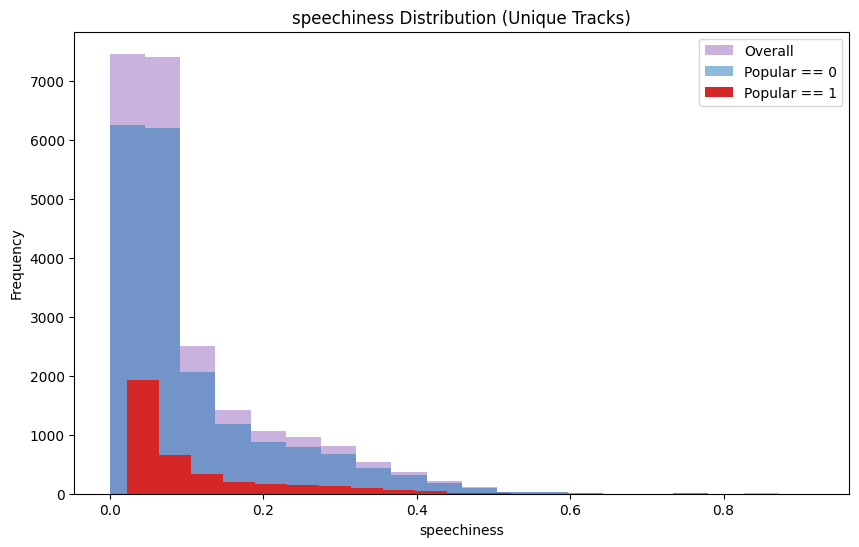

<Figure size 800x600 with 0 Axes>

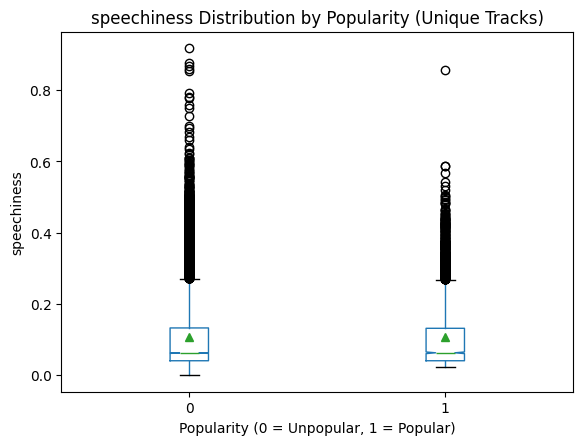

In [ ]:
analyze_column_distribution_continuous(data_1, 'speechiness')

### `acousticness`
**Implcation**

The acousticness distribution shows that most tracks have low acousticness values (<0.2), indicating they are predominantly electronic or amplified. Popular tracks (red) follow a similar pattern but have a slightly higher mean acousticness compared to unpopular tracks (blue), suggesting that tracks with some acoustic elements might have a marginally higher chance of being popular. High acousticness tracks (>0.8) are rare and appear equally in both popular and unpopular categories, reflecting their niche appeal.

In the Spotify dataset, **acousticness** measures the likelihood that a track is acoustic, meaning it relies primarily on non-electric, traditional instruments rather than electronic or synthesized sounds. It is represented as a numerical value between **0.0 and 1.0**.

**Key Characteristics** :
- **Range**:
  - **Close to 0.0**: The track is unlikely to be acoustic and relies heavily on electronic or amplified elements.
  - **Closer to 1.0**: The track is highly acoustic, featuring minimal electronic processing and traditional instruments.

- **Interpretation**:
  - Tracks with high acousticness often include instruments like acoustic guitars, pianos, strings, or percussion, and lack electronic beats or effects.
  - Tracks with low acousticness are more likely to feature electronic beats, synthesizers, or heavy amplification.

**Applications:**
1. **Genre Classification**:
   - High acousticness values are often associated with genres like folk, classical, or acoustic singer-songwriter music.
   - Low acousticness values are typical of genres like EDM, hip-hop, or pop.

2. **Playlist Curation**:
   - Useful for creating playlists with a specific vibe, such as an "unplugged" playlist featuring acoustic tracks.

3. **Mood Analysis**:
   - Acoustic tracks are often perceived as more organic, intimate, or soothing, making acousticness valuable for mood-based playlists.

**Examples:**
- A classical piano solo would have an **acousticness** close to **1.0**.
- A pop song with electronic beats might have an **acousticness** near **0.3**.
- An EDM track with heavy synthesizers and no acoustic instruments would have an **acousticness** close to **0.0**.

In summary, **acousticness** provides a measure of how "organic" or "traditional" a track is, offering insights into its production style and instrumentation.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean       0.176607      0.194095      0.173161
std        0.222346      0.218942      0.222855
min        0.000000      0.000013      0.000000
25%        0.014300      0.027275      0.012500
50%        0.079300      0.110500      0.073300
75%        0.259000      0.287000      0.251250
max        0.994000      0.983000      0.994000


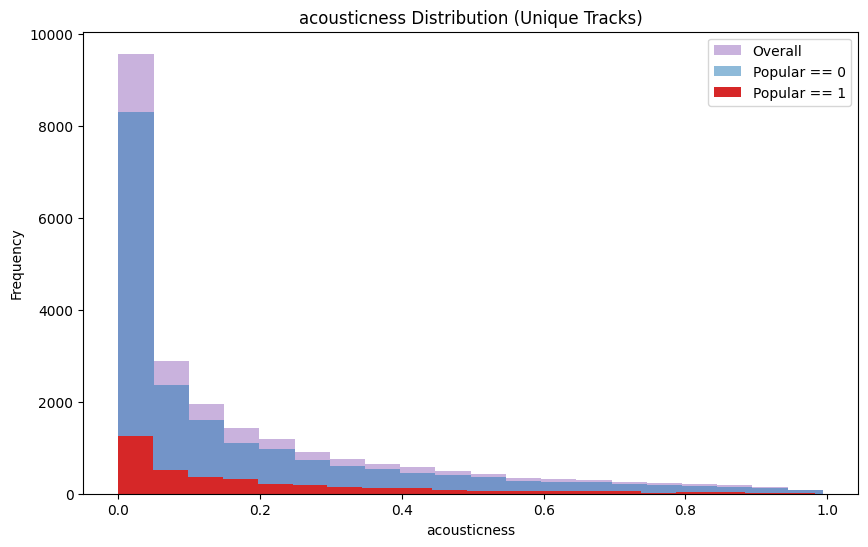

<Figure size 800x600 with 0 Axes>

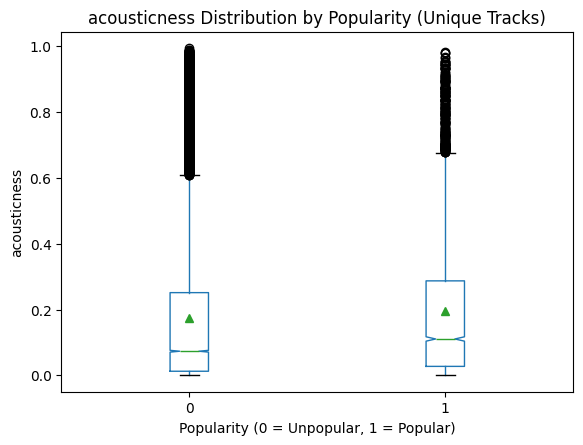

In [ ]:
analyze_column_distribution_continuous(data_1, 'acousticness')

### `instrumentalness`

**Implication**

The instrumentalness distribution shows that most tracks have very low instrumentalness values (close to 0), indicating the majority of tracks contain vocals. Popular tracks (red) tend to have even lower instrumentalness compared to unpopular tracks (blue), suggesting that vocal-heavy tracks are more likely to gain popularity. Fully instrumental tracks (values near 1) are rare and primarily belong to the unpopular category, reflecting their niche appeal.

In the Spotify dataset, instrumentalness measures the likelihood that a track contains no vocals. It provides an indication of whether the track is primarily instrumental (e.g., classical pieces, movie scores, or electronic instrumentals). It is represented as a value between 0.0 and 1.0.

Key Characteristics:
Range:

Close to 0.0: The track is unlikely to be instrumental and likely contains prominent vocals.
Closer to 1.0: The track is highly likely to be instrumental, with minimal or no vocal content.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean       0.089855      0.019528      0.103709
std        0.231102      0.099640      0.246593
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000020      0.000001      0.000041
75%        0.006245      0.000140      0.012800
max        0.994000      0.925000      0.994000


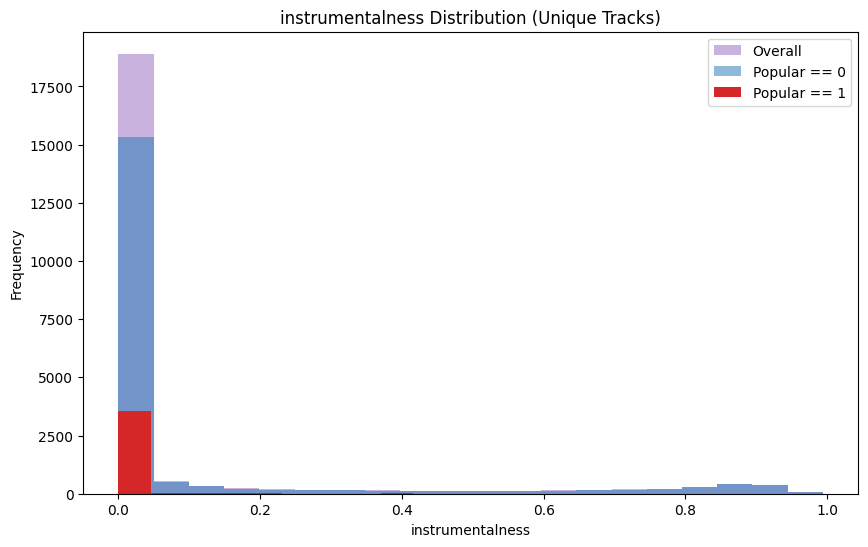

<Figure size 800x600 with 0 Axes>

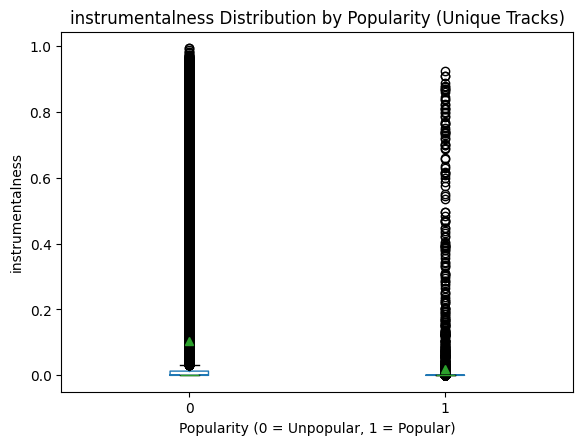

In [ ]:
analyze_column_distribution_continuous(data_1, 'instrumentalness')

### `liveness`
**Implication**

The liveness distribution indicates that most tracks have low liveness values (<0.2), suggesting they are likely studio recordings with minimal audience or live performance elements. Popular tracks (red) follow a similar trend, slightly leaning toward lower liveness values compared to unpopular tracks (blue). This suggests that studio recordings are generally more popular than live recordings.

Tracks with higher liveness values (>0.6), which indicate live performance characteristics (e.g., audience noise or ambiance), are rare and evenly distributed between popular and unpopular categories, reflecting their niche appeal.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean       0.191351      0.180243      0.193539
std        0.155238      0.143182      0.157415
min        0.000000      0.016500      0.000000
25%        0.092975      0.092800      0.093000
50%        0.128000      0.124000      0.129000
75%        0.251000      0.224000      0.256000
max        0.994000      0.971000      0.994000


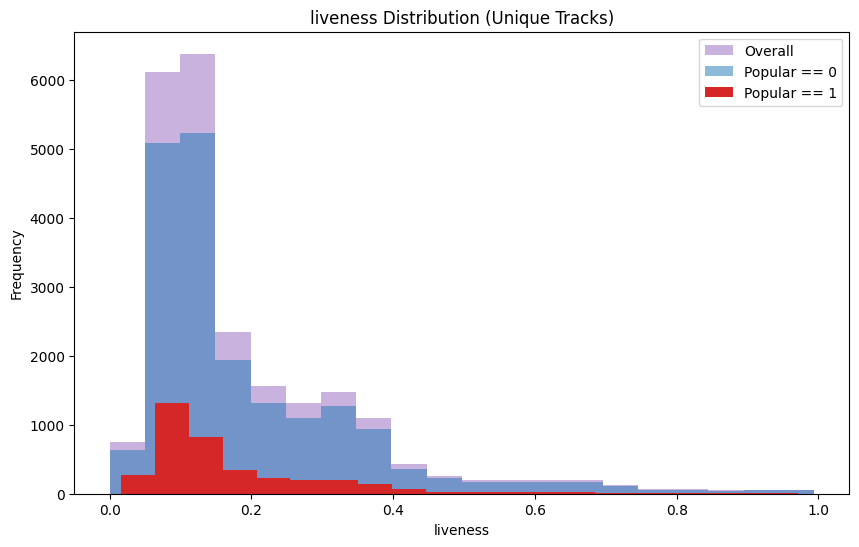

<Figure size 800x600 with 0 Axes>

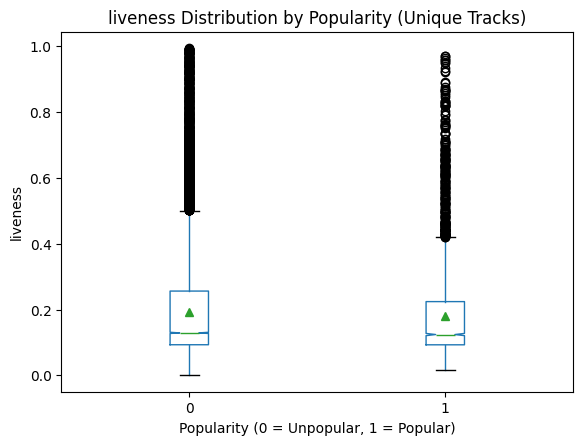

In [ ]:
analyze_column_distribution_continuous(data_1, 'liveness')

### `valence`

**Implication**

The valence distribution shows most tracks cluster around 0.5, reflecting balanced emotional tones. Popular tracks have a slightly higher average valence (0.53) compared to unpopular ones (0.50), indicating a preference for more positive and uplifting tracks. Both categories span the full valence range, but popular tracks lean slightly toward higher positivity.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean       0.508964      0.530745      0.504673
std        0.233749      0.224431      0.235309
min        0.000000      0.015900      0.000000
25%        0.329000      0.355750      0.322000
50%        0.511000      0.530000      0.507000
75%        0.692000      0.710000      0.690000
max        0.991000      0.985000      0.991000


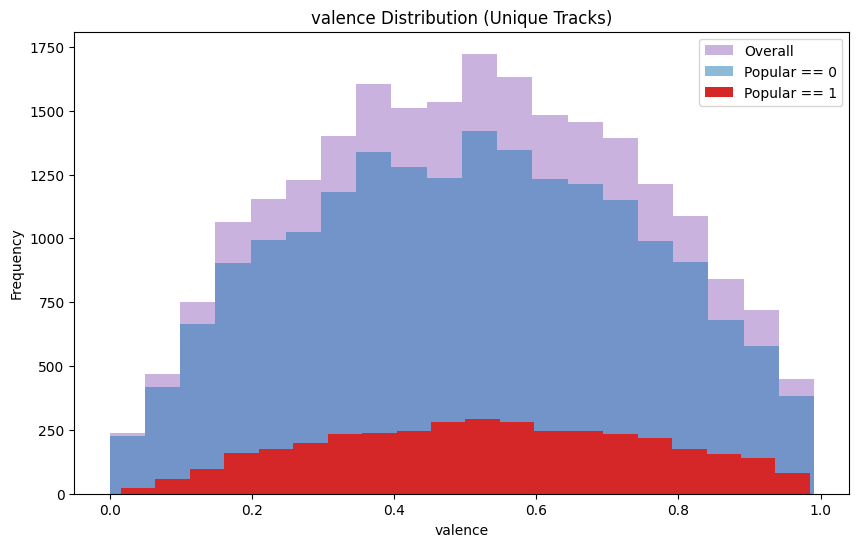

<Figure size 800x600 with 0 Axes>

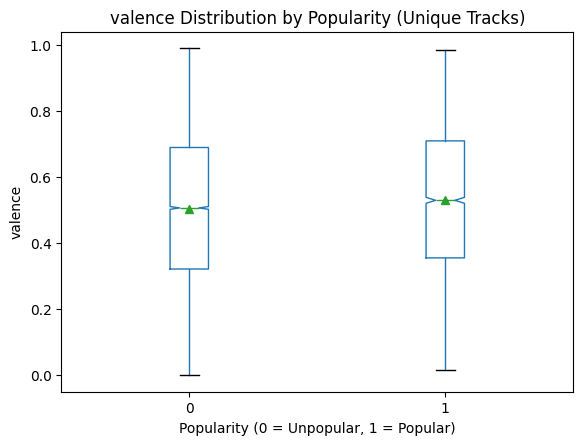

In [ ]:
analyze_column_distribution_continuous(data_1, 'valence')

### `tempo`

**Implication**

The tempo distribution shows that most tracks cluster around 100–130 BPM, with a peak near 120 BPM, which aligns with the tempo of many popular music genres. Popular tracks (red) closely follow this trend, with a slightly higher mean tempo (121 BPM) compared to unpopular tracks (120 BPM). This indicates a slight preference for faster tracks in popular music. Extremely high or low tempo tracks are rare, suggesting they cater to niche audiences.

Summary Statistics:
            Overall  Popular == 1  Popular == 0
count  22944.000000   3776.000000  19168.000000
mean     120.931571    121.104765    120.897453
std       26.951310     28.088743     26.722160
min        0.000000     48.718000      0.000000
25%       99.962000     98.047750     99.984750
50%      121.989000    119.965000    122.042500
75%      133.966750    137.947750    132.740500
max      220.252000    214.047000    220.252000


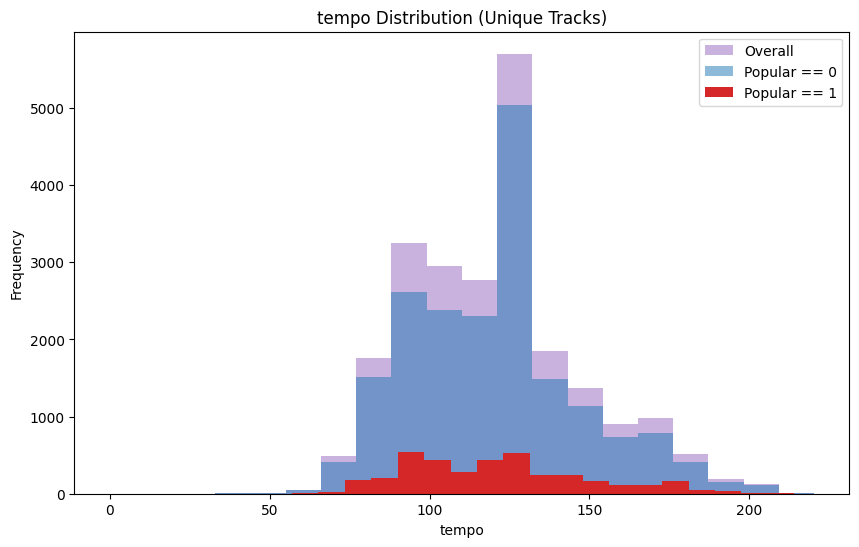

<Figure size 800x600 with 0 Axes>

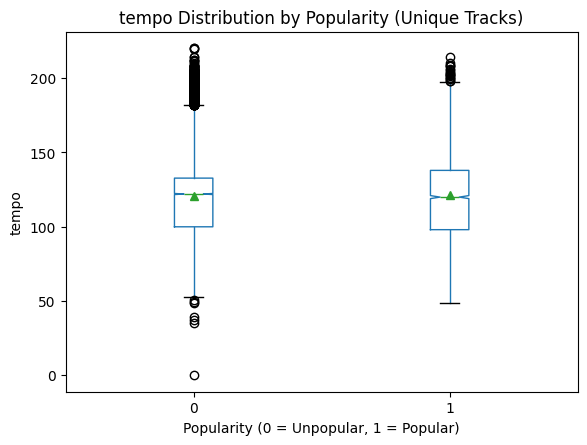

In [ ]:
analyze_column_distribution_continuous(data_1, 'tempo')

### `duration_ms`

**Implication**

The duration_ms distribution indicates that most tracks have durations between 180,000 ms (3 minutes) and 300,000 ms (5 minutes), aligning with the typical length of mainstream songs. Popular tracks (red) have a slightly shorter mean duration (\~219,801 ms or \~3.7 minutes) compared to unpopular tracks (\~227,629 ms or \~3.8 minutes). This suggests that slightly shorter songs may be more likely to gain popularity. Very short or very long tracks are rare and appear less popular, indicating a preference for standard-length tracks among listeners.

Summary Statistics:
             Overall   Popular == 1   Popular == 0
count   22944.000000    3776.000000   19168.000000
mean   226656.767129  219954.850371  227977.011164
std     60647.719859   49977.365001   62451.831452
min      4000.000000   79360.000000    4000.000000
25%    188000.000000  188502.000000  187857.750000
50%    217143.000000  213316.000000  218022.500000
75%    255163.250000  243043.250000  257760.250000
max    517810.000000  516893.000000  517810.000000


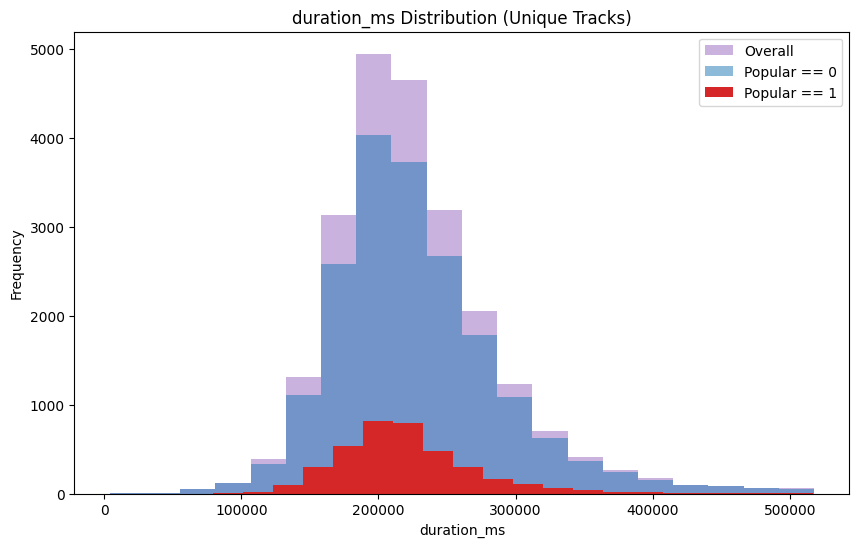

<Figure size 800x600 with 0 Axes>

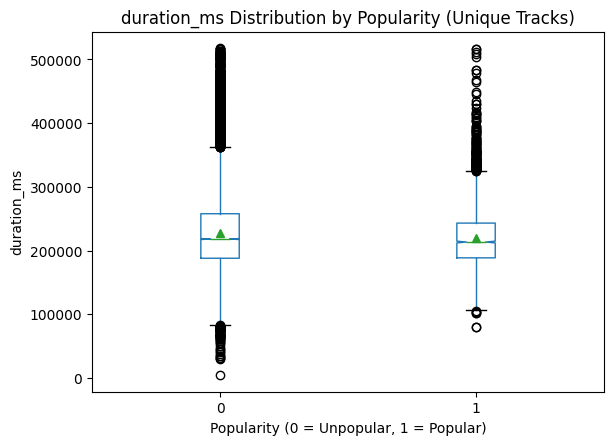

In [ ]:
analyze_column_distribution_continuous(data_1, 'duration_ms')

## Bivariate and Multivariate **Analysis**

### Correlation Heatmap

**Implication**

- Positive Correlations: Energy strongly correlates with loudness (0.68), and danceability with valence (0.33).
- Negative Correlations: Acousticness inversely correlates with energy (-0.54) and loudness (-0.37).
- Weak Correlations: Tempo, instrumentalness, and liveness show minimal correlations with other features.

In [ ]:
data_1.columns

Index(['track_id', 'track_name', 'track_artist', 'popular', 'release_year',
       'release_month', 'playlist_genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'date', 'key_mode'],
      dtype='object')

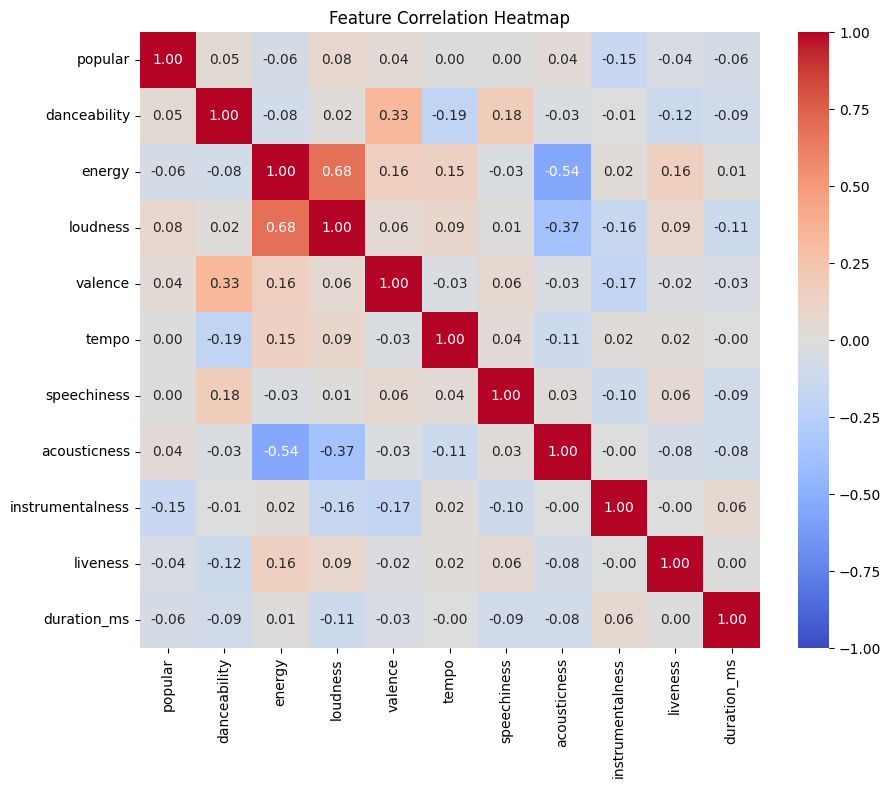

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data_1[['popular','danceability', 'energy', 'loudness', 'valence',
                             'tempo', 'speechiness', 'acousticness', 'instrumentalness',
                             'liveness', 'duration_ms']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


### Boxplot of Features by Playlist Genre

**Implication**

Based on the boxplots for numerical features across playlist genres:

1. **Danceability**: EDM and Latin genres have higher danceability medians compared to rock and R&B.
2. **Energy**: EDM and Rock exhibit the highest energy, while R&B and Latin show relatively lower energy medians.
3. **Loudness**: EDM and Rock are the loudest genres, consistent with their high energy levels, while R&B and Latin are quieter.
4. **Speechiness**: Rap has a significantly higher speechiness median compared to other genres, reflecting its spoken-word style.
5. **Acousticness**: R&B and Latin have higher acousticness, indicating a more organic sound, while EDM shows the lowest.
6. **Instrumentalness**: EDM leads with the highest instrumentalness, whereas other genres (e.g., Rap, R&B) are primarily vocal-heavy.
7. **Liveness**: The liveness distributions are similar across genres, with EDM slightly higher, indicating a more live-performance feel.
8. **Valence**: Latin and Pop songs show higher valence (happiness), while Rock and R&B are more neutral.
9. **Tempo**: EDM and Rock have higher tempo variability, while Rap and Latin are more stable.
10. **Duration**: Rock and Latin genres generally have longer song durations, while EDM has relatively shorter tracks.

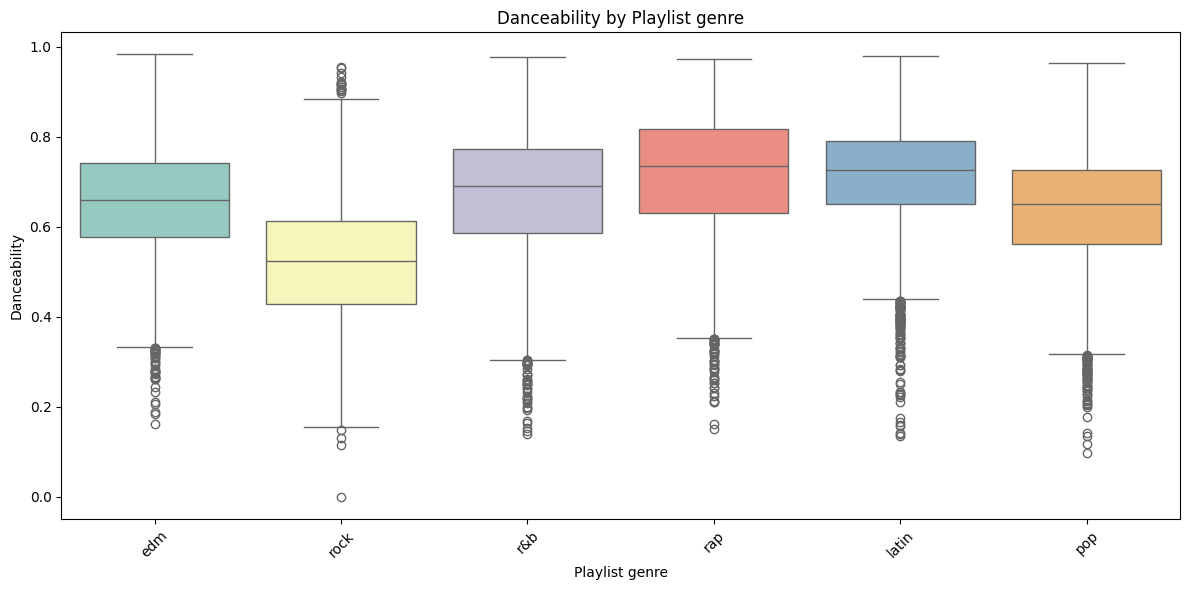

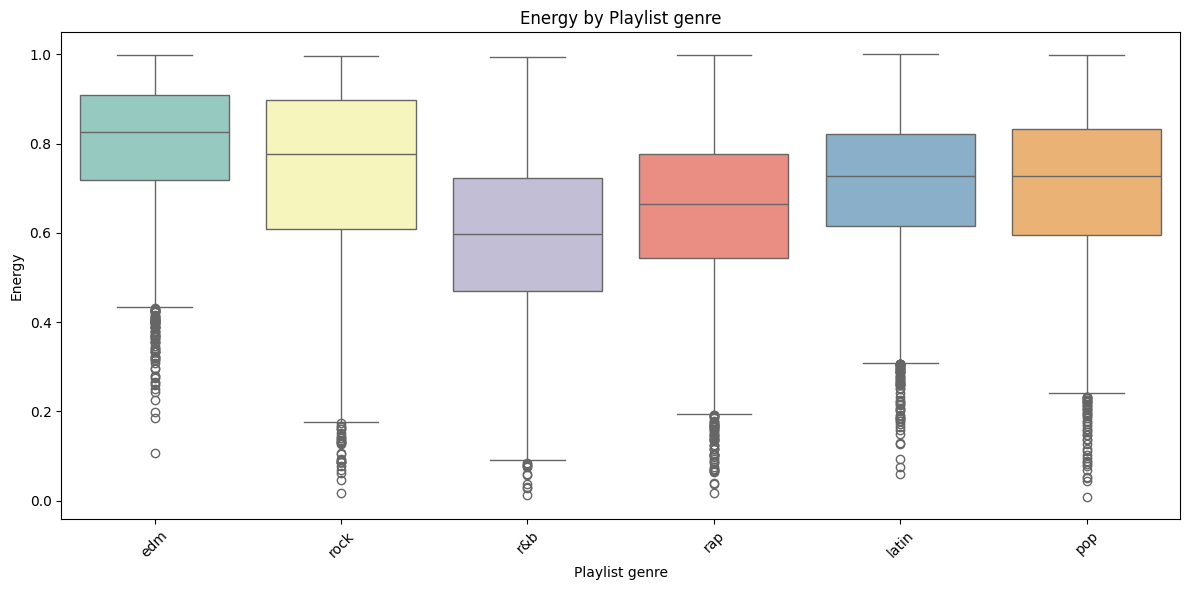

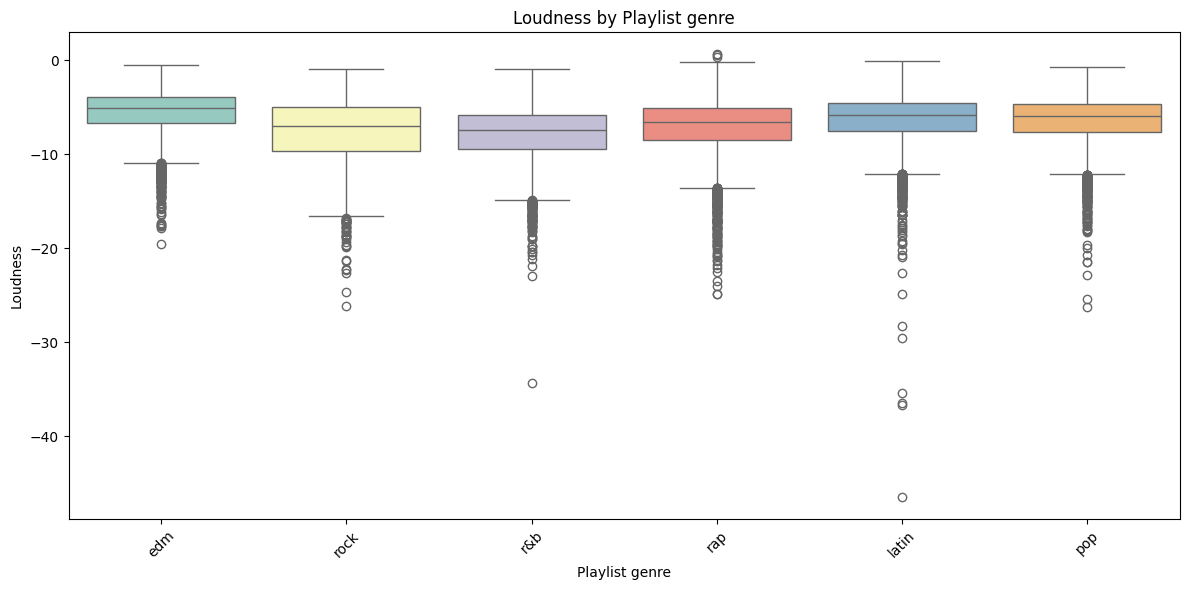

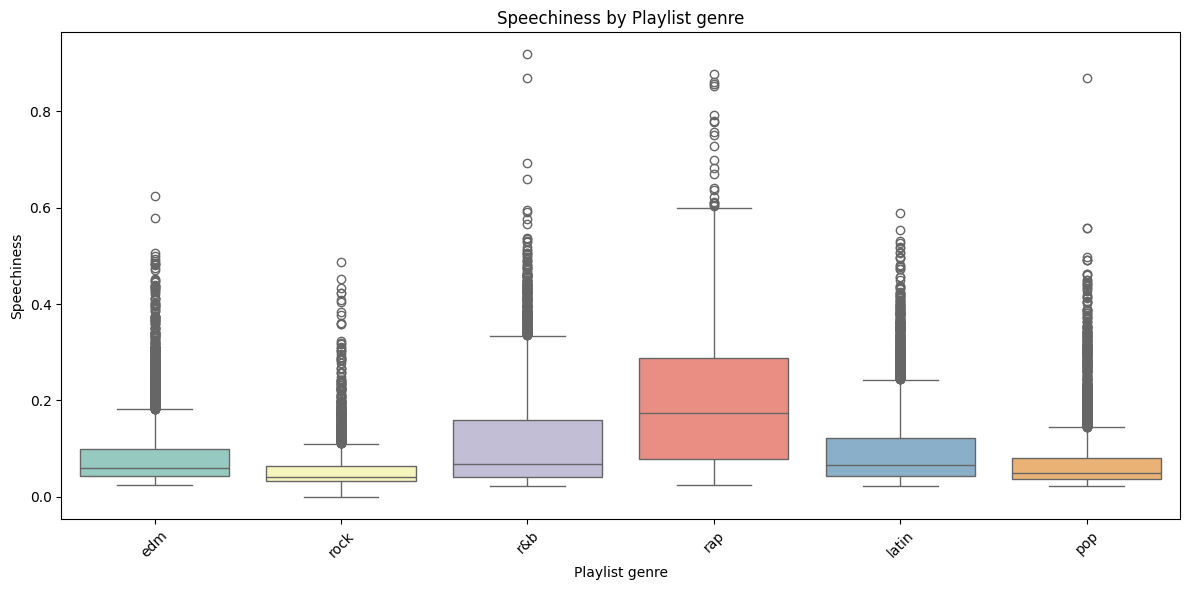

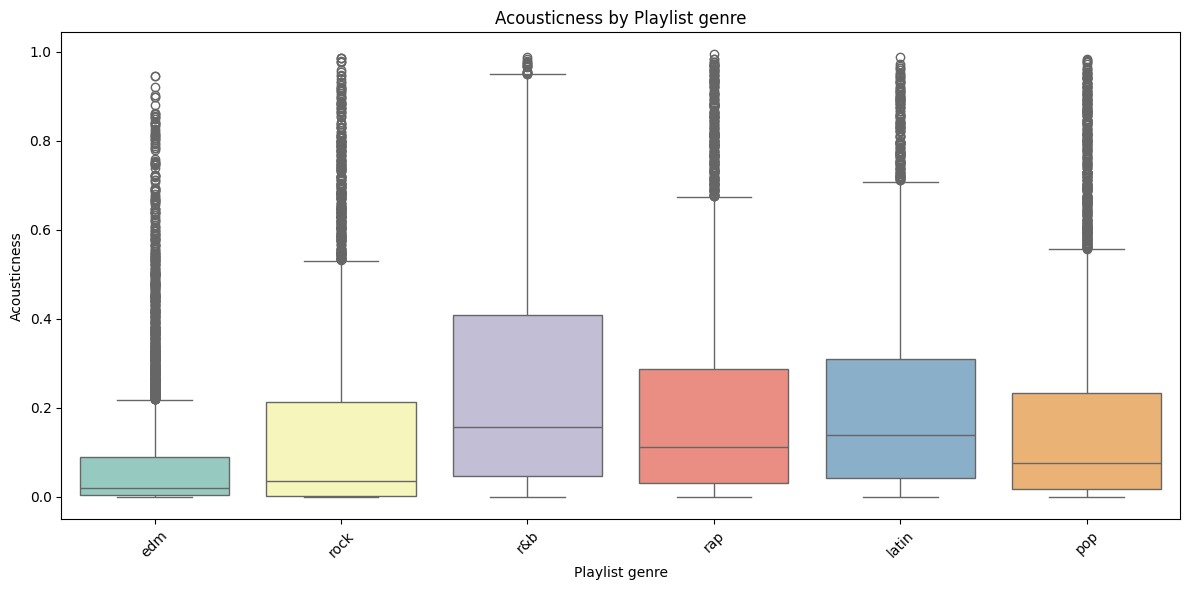

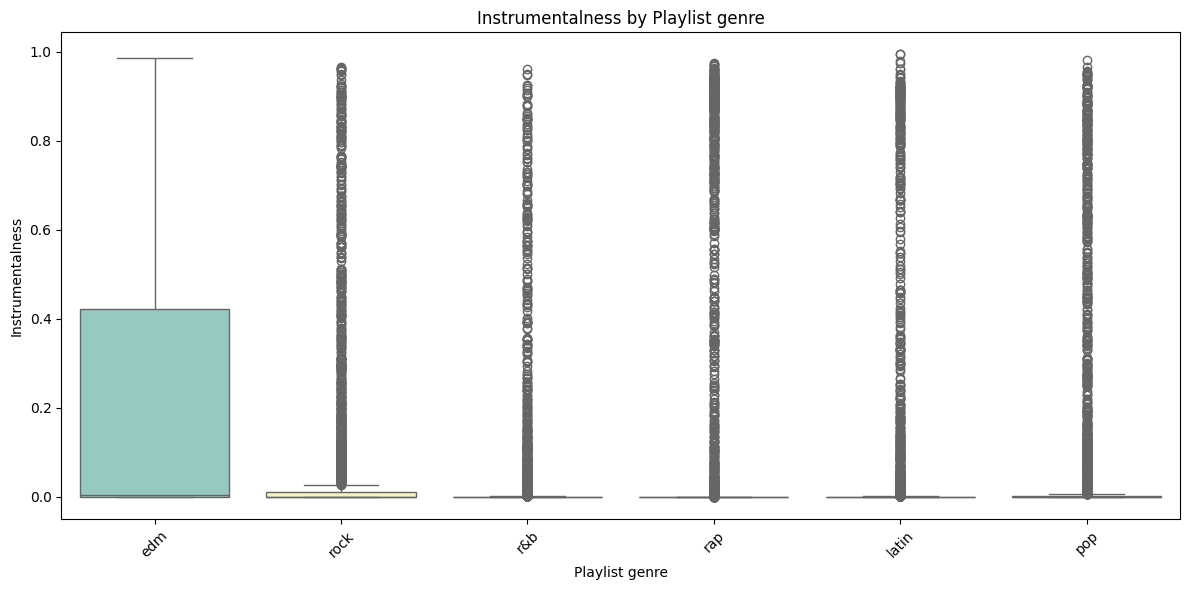

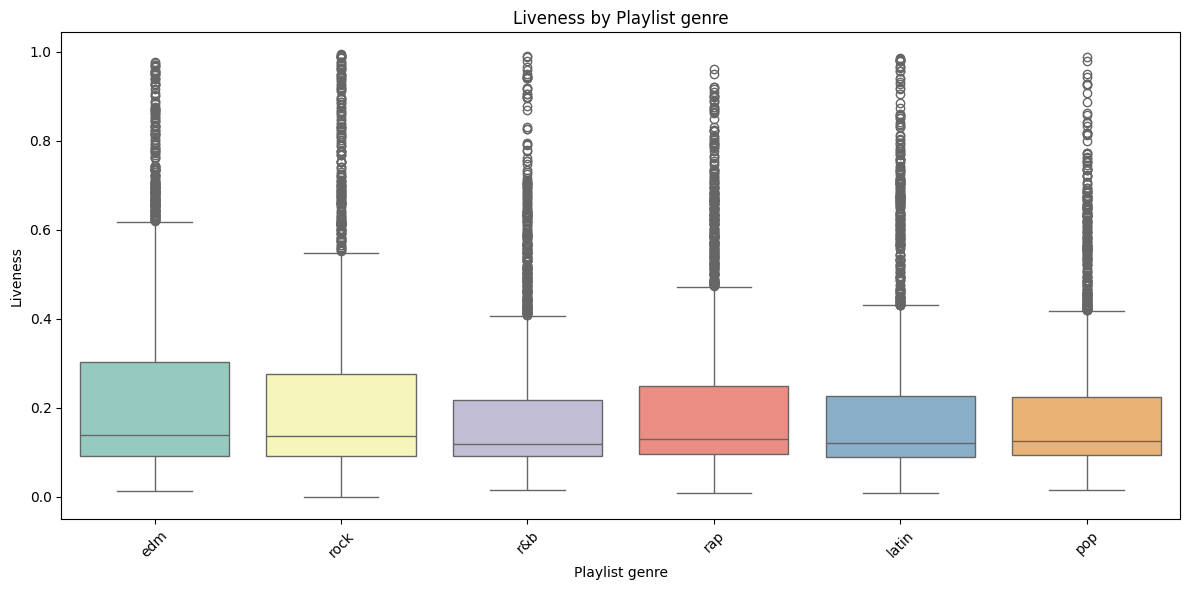

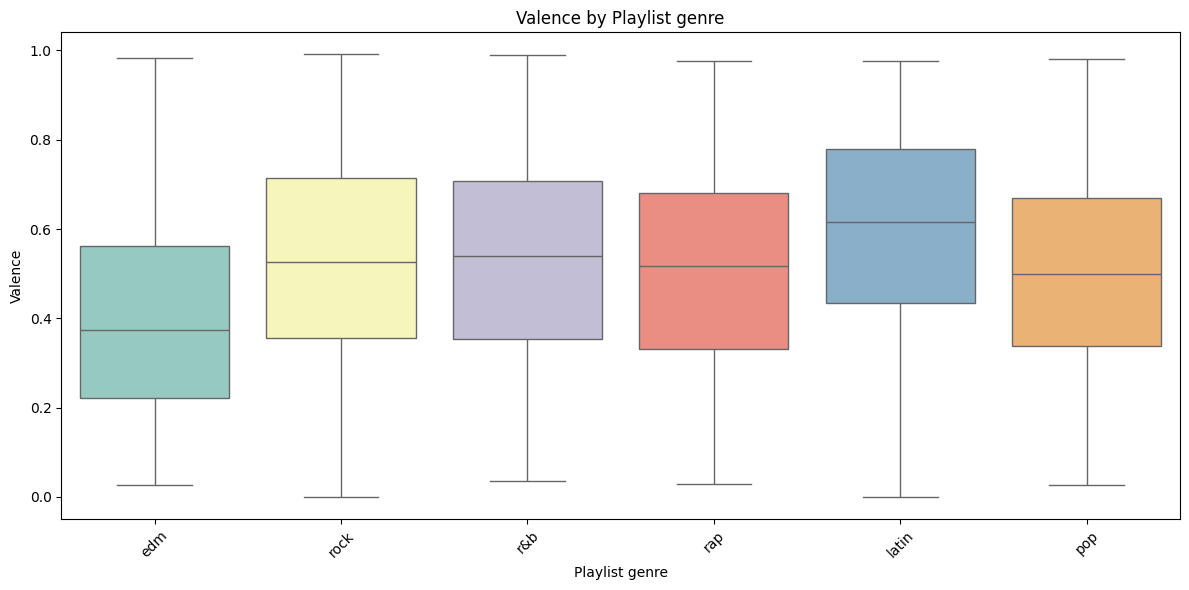

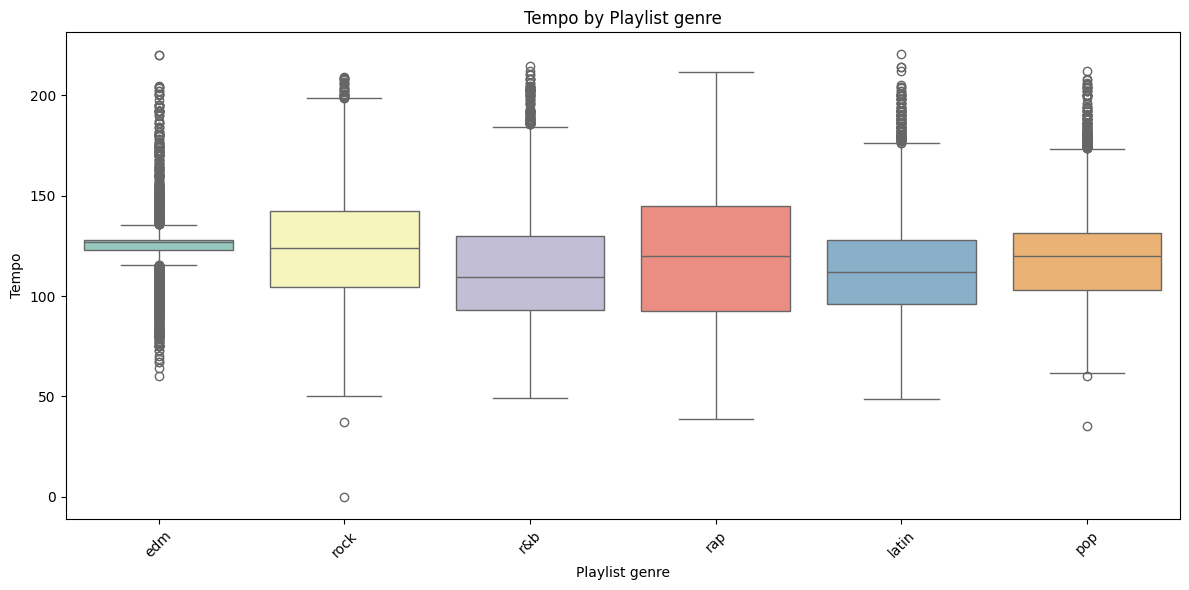

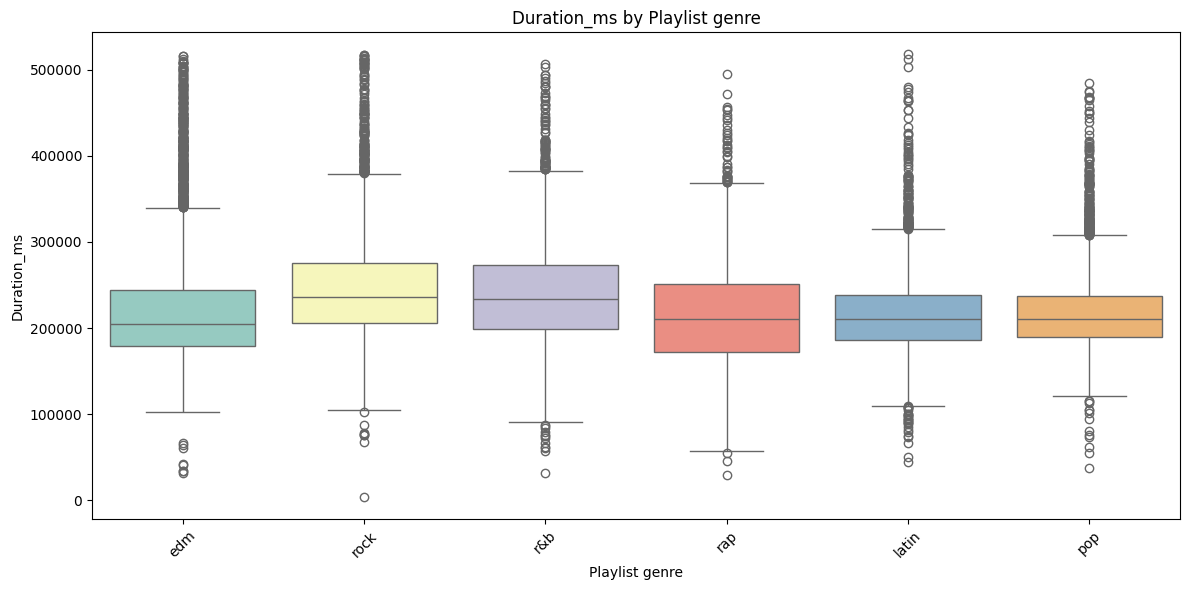

In [ ]:
numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence',
                     'tempo', 'duration_ms']

plot_boxplots_by_genre(data_1, numerical_columns)


###  Yearly Trends in Numerical Columns

**Implication**

There is significant variance in the data from older periods, particularly between 1950 and 1990, which could be attributed to data errors or biased sample sizes. Additionally, trends and variances appear to differ across time periods. In more recent years, the average characteristics of popular songs have diverged from those of the total sample in terms of speechiness, energy, and danceability. It's important to note that this analysis does not account for the fact that certain genres are more likely to become popular, which could contribute to these divergences



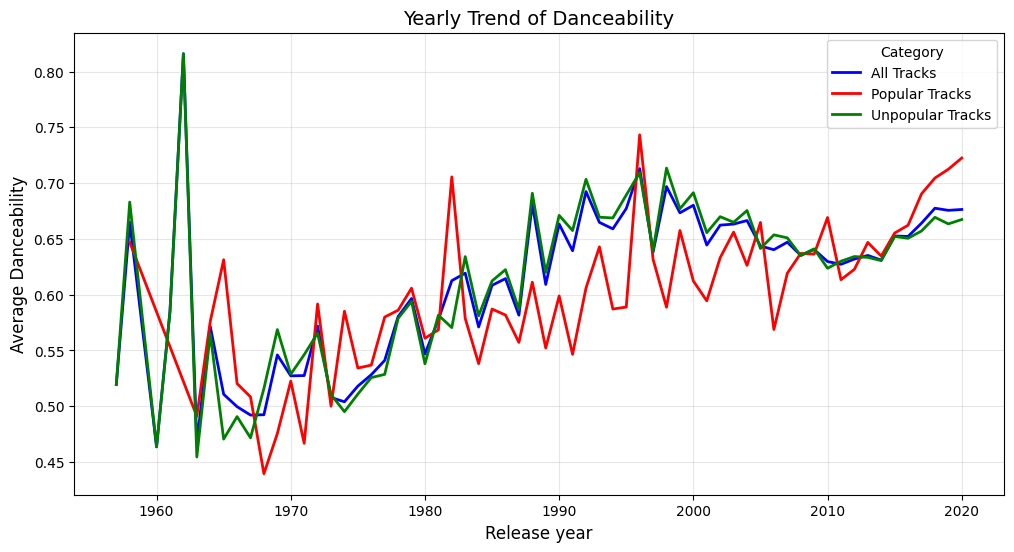

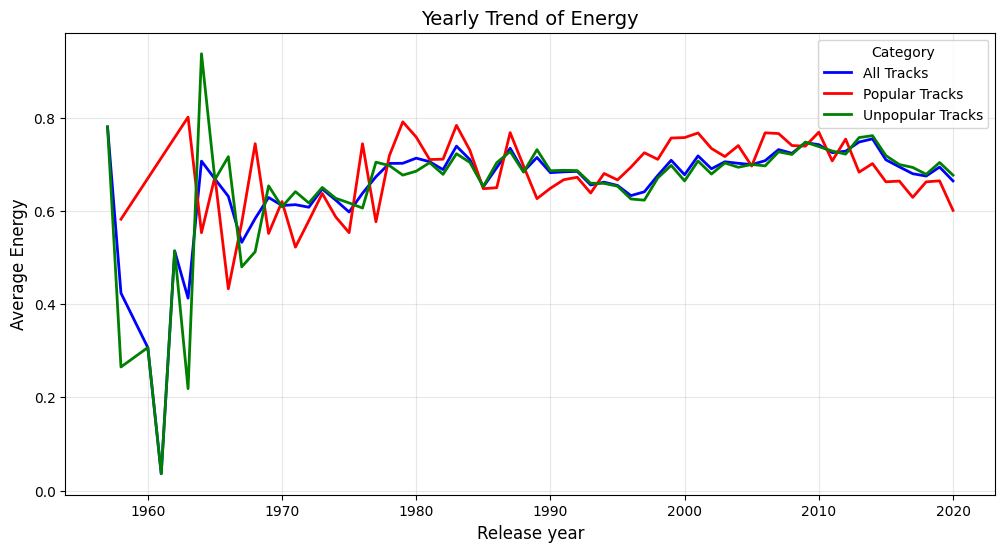

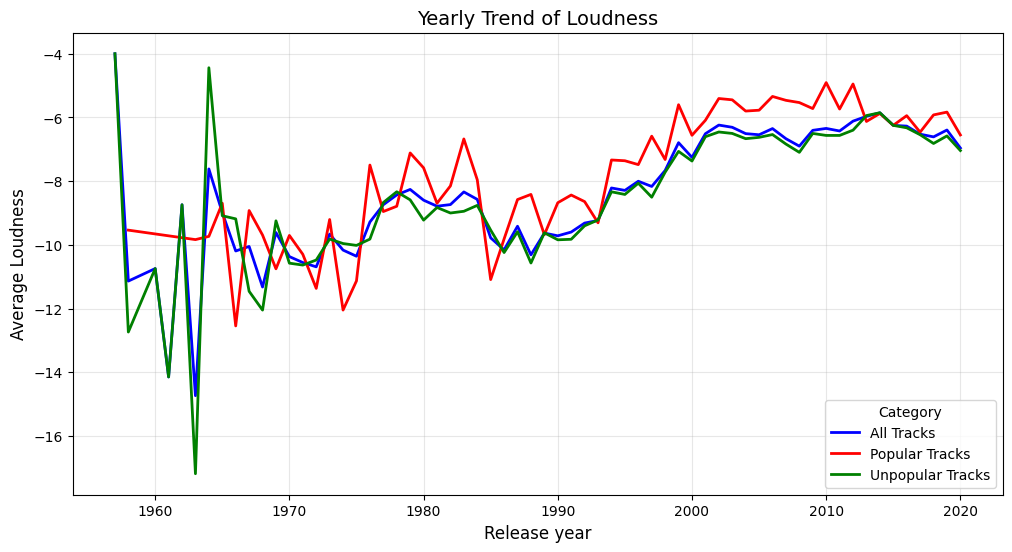

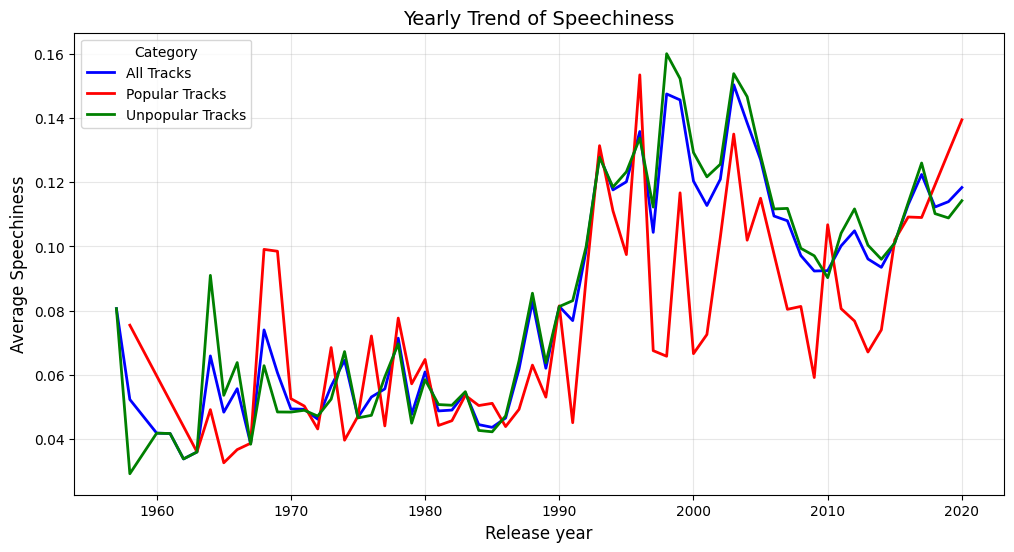

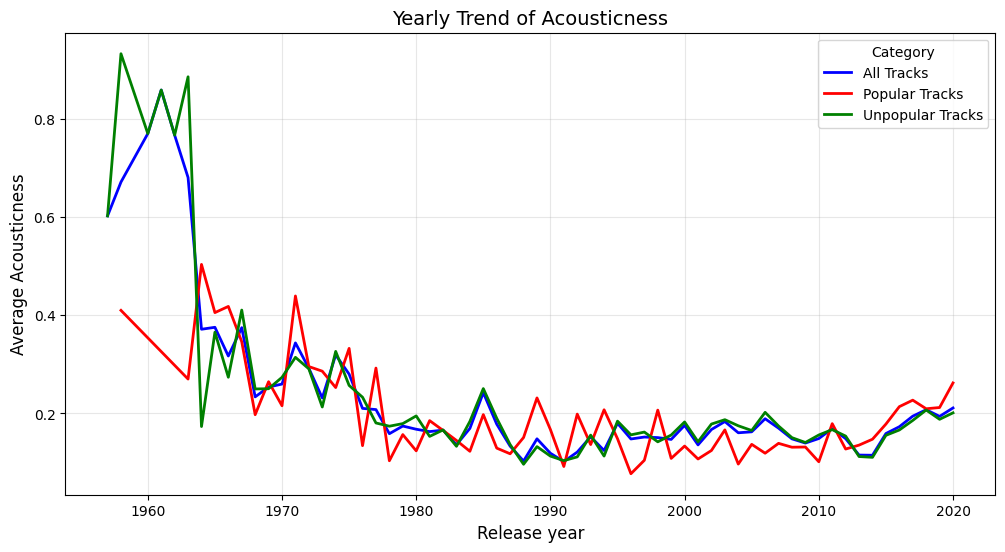

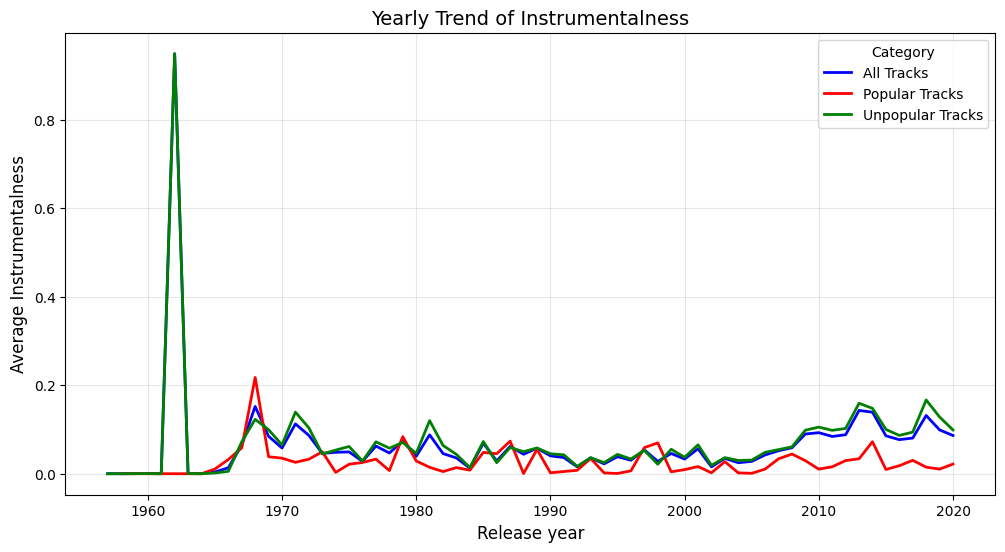

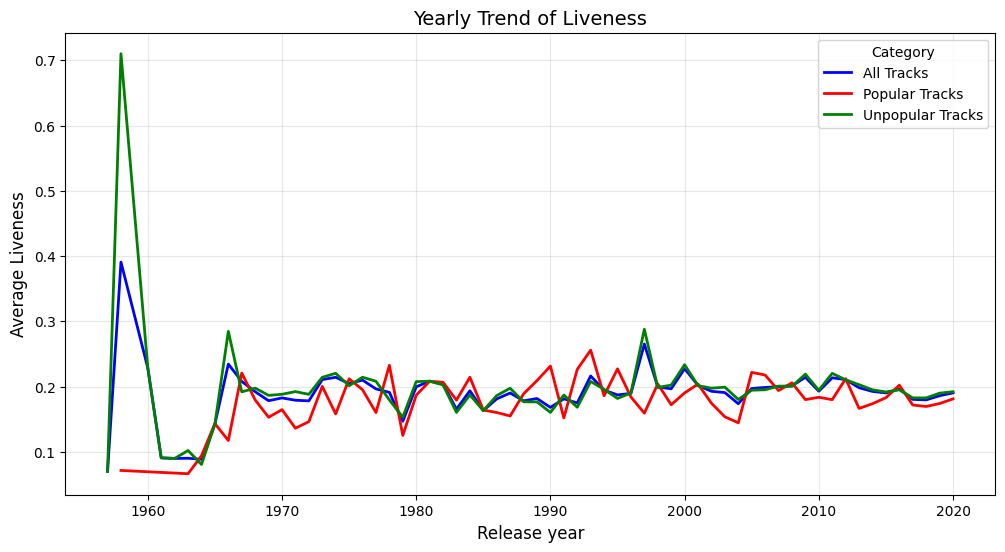

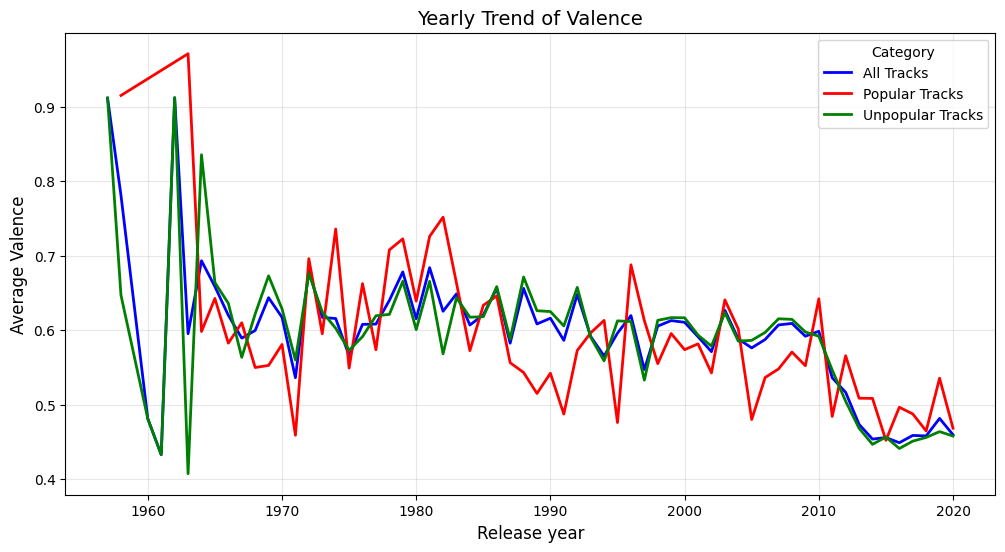

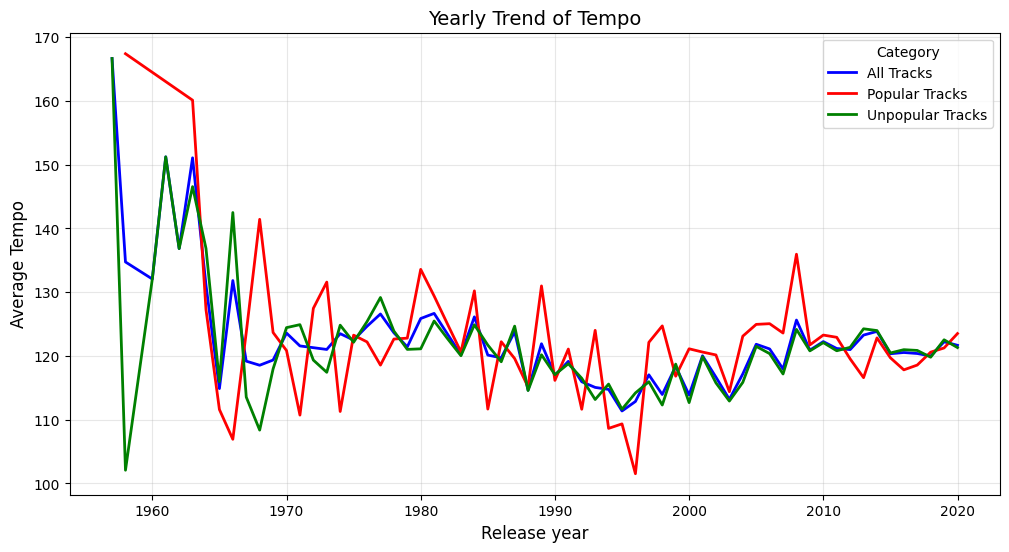

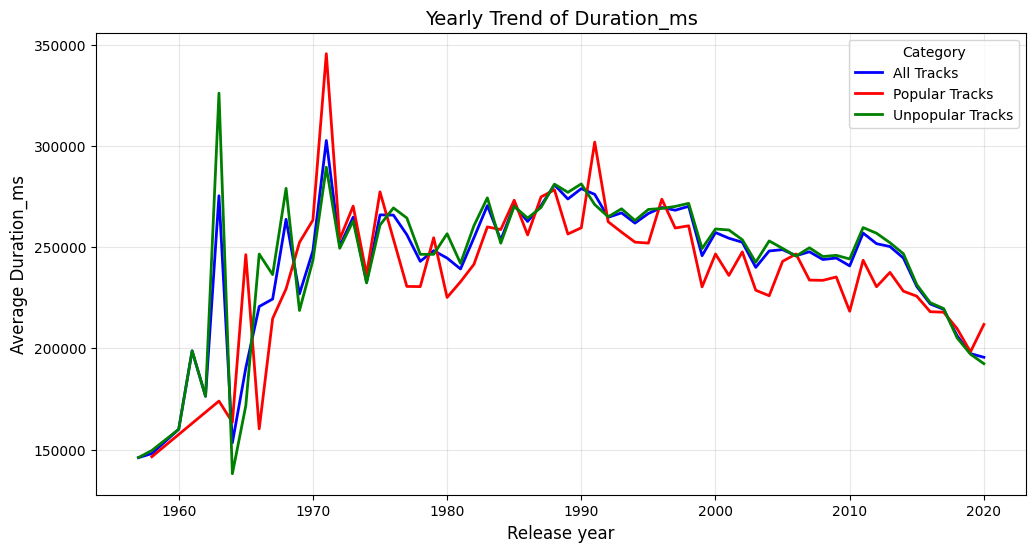

In [ ]:
numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness','liveness', 'valence',
                     'tempo', 'duration_ms']

for col in numerical_columns:
    plot_yearly_trends(data=data_1, numerical_column= col, group_column='release_year')

### Cluster Analysis (K-Means)

(todo: More work could be done in this and PCA)

**Implication**

It is unclear if different clusters vary in popularity.


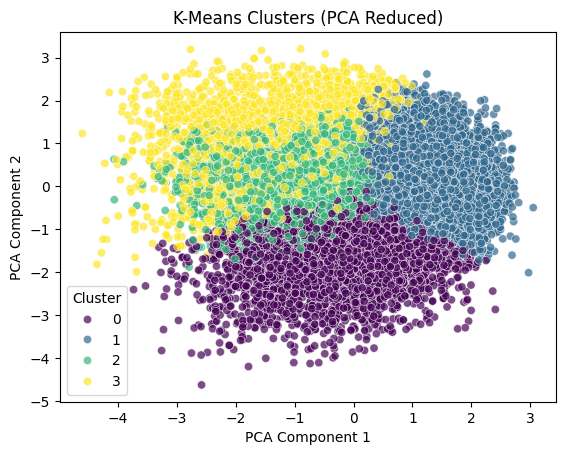

In [ ]:

# Select features for clustering
features = data_1[['danceability', 'energy', 'valence', 'tempo']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data_1['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
data_1['pca_1'] = pca_result[:, 0]
data_1['pca_2'] = pca_result[:, 1]

sns.scatterplot(data=data_1, x='pca_1', y='pca_2', hue='cluster', palette='viridis', alpha=0.7)
plt.title("K-Means Clusters (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


### Principal Component Analysis (PCA)

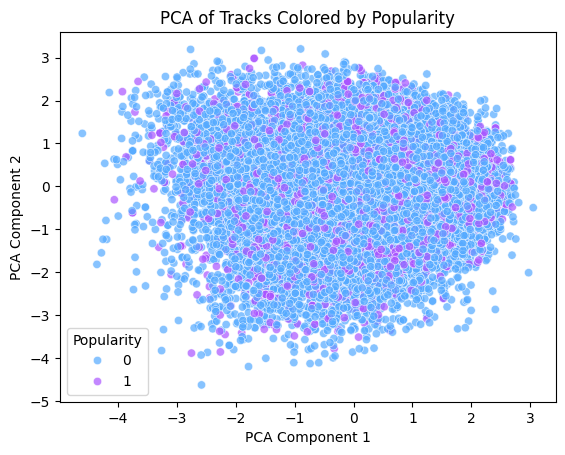

In [ ]:
# PCA visualization
sns.scatterplot(data=data_1, x='pca_1', y='pca_2', hue='popular', palette='cool', alpha=0.7)
plt.title("PCA of Tracks Colored by Popularity")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Popularity")
plt.show()


In [ ]:
data_1.drop(columns=['cluster', 'pca_1', 'pca_2'], inplace=True)
data_1

track_id                     track_name    track_artist  \
0      697MjF1454XKvZmTuqkWmD                     I Miss You          Jeriqo   
1      3x2bXiU0o4WbsPkawXlfDA                    Who Are You         The Who   
2      0jEaPBjFAWjQTMVouRwaHi                          Happy  The Beef Seeds   
3      5EKUb1FKsyYVaSXb41YBIj                            ONE      Rev Theory   
4      300DUx4tdtCdGEUXR032jA                   Palace/Curse    The Internet   
...                       ...                            ...             ...   
24364  6bE9Ud8C8stzPwu7xJRx9u                          Tokyo           Drevm   
24365  29ikXeGM6kScvhvqfvgiwO                  Drunken Truth      Steve Void   
24366  47zREtxQZ3cHHIZwUQnuuN  Never Be Like You (feat. Kai)           Flume   
24367  61swngFBghaxXM0YT7CDU1        Symphony - Original Mix    Sandro Silva   
24368  0oWHLtxWeMJhmwxtrxhNK0          Welcome To The Jungle   Guns N' Roses   

       popular  release_year  release_month playlist_genre  danceability  \
0            0          2019              2            edm         0.520   
1            0          1978              8           rock         0.651   
2            0          2015              1            r&b         0.640   
3            0          2020              1           rock         0.398   
4            0          2015              6            r&b         0.447   
...        ...           ...            ...            ...           ...   
24364        0          2019             12            rap         0.715   
24365        0          2019             12            pop         0.781   
24366        0          2016              5            edm         0.564   
24367        0          2014              8            edm         0.545   
24368        0          1987              1           rock         0.443   

       energy  key  loudness  mode  speechiness  acousticness  \
0       0.789    0    -7.717     1       0.0432      0.004910   
1       0.661    9   -11.405     1       0.0511      0.265000   
2       0.758   10    -5.204     1       0.1600      0.665000   
3       0.966    4    -2.352     0       0.0453      0.000006   
4       0.625   10    -8.212     0       0.3230      0.035100   
...       ...  ...       ...   ...          ...           ...   
24364   0.349    0   -10.519     1       0.2510      0.732000   
24365   0.745    1    -4.942     0       0.0374      0.081400   
24366   0.552    0    -5.438     1       0.0550      0.439000   
24367   0.774    0    -3.689     1       0.0440      0.001480   
24368   0.955    8    -8.066     1       0.0741      0.022200   

       instrumentalness  liveness  valence    tempo  duration_ms       date  \
0              0.000013    0.0816    0.415  174.026       216347 2019-02-01   
1              0.003130    0.1060    0.489  156.371       378707 1978-08-01   
2              0.000000    0.1270    0.932   86.529       218044 2015-01-01   
3              0.000000    0.3030    0.520   90.016       208196 2020-01-01   
4              0.000727    0.2430    0.261   67.104       440013 2015-06-01   
...                 ...       ...      ...      ...          ...        ...   
24364          0.715000    0.0725    0.406   85.302       101295 2019-12-01   
24365          0.000097    0.1060    0.498  110.051       158091 2019-12-01   
24366          0.000000    0.1630    0.260  119.907       233337 2016-05-01   
24367          0.933000    0.5590    0.212  128.026       301890 2014-08-01   
24368          0.361000    0.2970    0.333  123.423       273600 1987-01-01   

      key_mode  
0          0_1  
1          9_1  
2         10_1  
3          4_0  
4         10_0  
...        ...  
24364      0_1  
24365      1_0  
24366      0_1  
24367      0_1  
24368      8_1  

[24369 rows x 21 columns]